# Toplotne potrebe

When2Heat set podataka se sastoji od sintetskih vremenskih nizova toplotnih potreba i koeficijenta učinka toplotnih pumpi za 16 evropskih država u periodu 2008 - 2018. na satnoj rezoluciji. Profili toplotnih potreba za grijanje prostora i PTV su izračunati na osnovu profila potrošnje gasa, temperature i brzine vjetra uz faktor populacije. U nastavku je analiza podataka koji su izdvojeni za Hrvatsku, i dostupni u periodu 2008 - 2013, s obzirom na slične parametre populacije i klimatskih uslova kao u BiH. Ovi podaci su se skupa sa ukupnim potrebama po različitim tipovima objekata iz literature iskoristili za procjenu toplotnih potreba u BiH na satnoj osnovi. Set podataka, skripte i ulazni parametri su dostupni na Open Power System Data platform.
<br>https://open-power-system-data.org/
<br>https://github.com/oruhnau/when2heat
<br>https://www.nature.com/articles/s41597-019-0199-y.pdf
## Metodologija po kojoj je dobiven set podataka
Metodologija po kojoj je je napravljen set podataka je donekle dešifrovana, međutim, problem predstavlja nemogućnost sagledavanja geografskih podataka što djelimično otežava potpuno razumijevanje algoritma.
Osnova za satne toplotne potrebe je satni profil potrošnje gasa u Njemačkoj na način kako to definišu Udruženje njemačke privrede za gas i hidrotehniku BGW, te za energiju i hidrotehniku - BDEW. https://www.enwg-veroeffentlichungen.de/badtoelz/Netze/Gasnetz/Netzbeschreibung/LF-Abwicklung-von-Standardlastprofilen-Gas-20110630-final.pdf, *Dodatno bi se trebao analizirati ovaj dokument za bolji uvid u čitavu metodologiju*
<br>Za svaku državu su prikupljeni podaci o temperaturi i brzini vjetra iz ERA Interim baze kako bi se dobile potrebe za grijanjem prostora i PTV na svim lokacijama unutar države. Podrazumijevajući da su potrebe za toplotom na različitim lokacijama uslovljene i populacijom, populacija je iskorištena kao težinski faktor za razvijene vremenske nizove. Podaci o populaciji su prikupljeni sa EUROSTAT-a i normalizirani na 1 TWh prosječne godišnje potrošnje. U razdoblju od 2008-2013 izvršeno je skaliranje ovih podataka sa godišnjom potrošnjom finalne energije za grijanje i PTV na osnovu EU baze objekata (EU Building database) i korekcija za gubitke konverzije. 

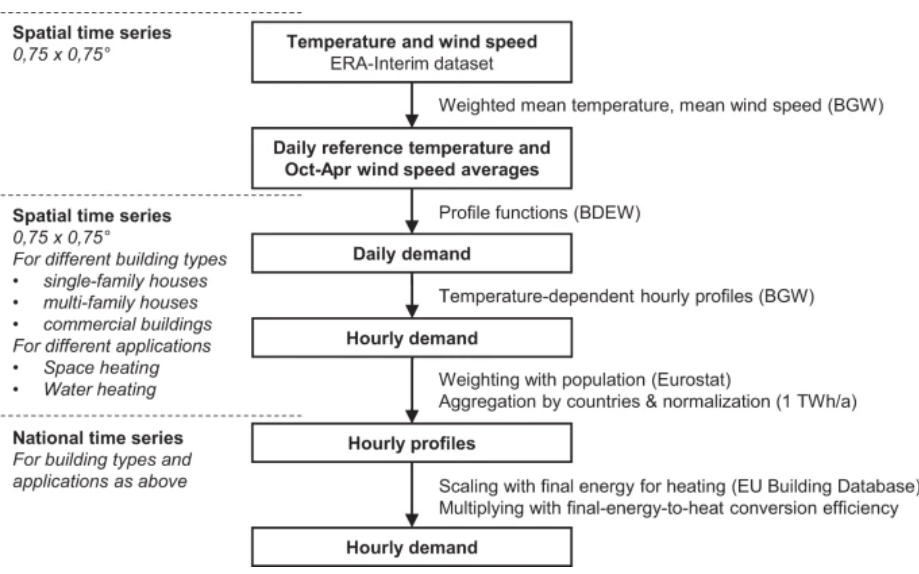

Meteorološki podaci iz ERA-Interim arhive nisu dostupni za BiH, ali ovi koji su korišteni u algoritmu za when2heat su prikupljeni na sajtu: European Centre for Medium-Range Weather Forecasts (ECMWF). Korišteni su paramteri:
<br>temperatura zraka na visini 2 m iznad tla
<br>temperatura tla 1-2.89 m ispod površine tla
<br>brzina vjetra na 10 m visine iznad zemlje.
<br>Temperature su prikupljene na šestosatnoj rezoluciji u periodu 2008 - 2018, a podaci o brzini vjetra u mjesečnoj rezoluciji u periodu 1979 - 2018. Parametri su određeni na prostornoj mreži od po 0.75× 0.75°, što je ekvivalentno 28x17 km. Za brzinu vjetra se uzimao prosjek grijnih sezona oktobar - april od 1979 do 2018. za svaku lokaciju na osnovu čega su one podijeljene u vjetrovita i nevjetrovita područja. Ovi podaci su iskorišteni za generisanje gasnih profila prema BGW I BDEW. Kao težinski faktor za željene vremenske nizove su iskorišteni podaci o populaciji sa Euostata (http://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/population-distribution-demography/geostat). Za skaliranje toplotnih potreba preuzeti su podaci o goidšnjoj potrošnji finalne energije za grijanje i PTV u stambenim i nestambeninm objektima (http://ec.europa.eu/energy/en/eu-buildings-database).
Vremenske toplotne potrebe su određene sa tri faktora - meterološkim uslovima, osobinama objekta i ponašanjem stanara. Za ovaj set podataak je izabrana njemačka metodologija za računanje standardnih profila potoršnje gasa koja u koriste distributeri gasa u slučaju kupaca kod kojih se ne vrši mjerenje na dnevnom nivou, sa pretpostavkom da rad kotla na gas prati stvarne toplotne potrebe i su gasom grijani objekti reprezentativni za ciijelo područje. 
Dnevne referentne temperature su izračunate za svaku od ERA-Interim lokacija. 
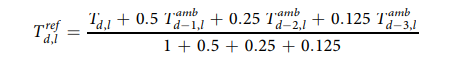

Kako bi se uključio efekat termalne inercije , referentna dnevna temperatura je definisana kao težinska srednja vrijednost prosječne temperature zraka za dati dan i odgovarajućih temperatura u 3 prethodna dana  za svaku lokaciju. Referentna temperatura je potrebna za računanje dnevnog faktora potreba $f_{d,l}$.

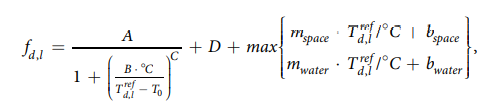
Profil - funkcija dnevnog faktora potreba se definira kao kombinacija simgoid funkcije i dvije linearne funkcije sa To=40°C. gdje parametri A, B, C, D, $m_{space}$, $b_{space}$, $m_{water}$, $b_{water}$,odgovaaju različitim tipovima objekata - individualnim, objektima kolektivnog stanovanja i komercijalnim zgradama. U slučaju kada je brzina vjetra veća od 4.4 m/s, primijenjena je sigmoid funkcija za vjetrovite lokacije, u suprotnom je lokaciji dodijeljena "normalna" kategorija. Nakon toga je satni profil dobijen iz dnevnih vrijednosti preko satnih faktora koji su dati za različite tipove objekata, deset temperaturnih opsega i različite dane u sedmici. Ovi satni faktori se mogu tumačiti kao udjeli u dnenvnim potrebama, tako da je njihova suma u toku dana 100%. 
Dnevni faktori grijanja vode se računaju kao:

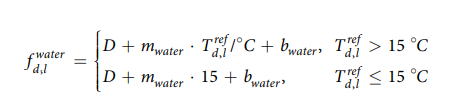

s tim da se linearni dio primjenjuje samo na temperature čija je vrijednost veća od onih u linearnoj funkciji grijanja. Ovo je u slučaju kada je granična vrijednost temperature grijanja 15°C. Za više temperature se pretpostavlja da potrebe za grijanjem PTV ostaju konstantne. Pod pretpostavkom da na visokim temperaturama zraka ne postoji grijanje postora, satni faktori za temperaturne opsege >25°C se odnose na PTV. Dnevni faktori za PTV su pomnoženi sa ovim visokotemperaturnim satnim faktorima, a potrebe za grijanjem prostora su izračunate kao razlika ukupnih toplotnih potreba i potreba za PTV. Negativne vrijednosti su postavljene na 9 (u toku ljeta).



In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file=pd.read_excel(r"FILES\HEAT\when2heat.xlsx",parse_dates=True,header=[0,1,2,3])

S obzirom da je dio podataka koji se odnosi na sezonski toplotni učinak toplotnih pumpi analiziran u drugom fajlu, u ovom fajlu su se zadržale one kolone koje se odnose na toplotne potrebe.

## Opcija 1: Struktura podataka

In [3]:
file=file.drop(file.columns[2:11],axis=1)

In [4]:
file=file.dropna(axis=0)

In [5]:
file.columns

MultiIndex([('country',     'variable', 'attribute',   'unit'),
            ('country',     'variable', 'attribute', 'unit.1'),
            (     'HR',  'heat_demand',     'space',     'MW'),
            (     'HR',  'heat_demand', 'space_COM',     'MW'),
            (     'HR',  'heat_demand', 'space_MFH',     'MW'),
            (     'HR',  'heat_demand', 'space_SFH',     'MW'),
            (     'HR',  'heat_demand',     'total',     'MW'),
            (     'HR',  'heat_demand',     'water',     'MW'),
            (     'HR',  'heat_demand', 'water_COM',     'MW'),
            (     'HR',  'heat_demand', 'water_MFH',     'MW'),
            (     'HR',  'heat_demand', 'water_SFH',     'MW'),
            (     'HR', 'heat_profile', 'space_COM', 'MW/TWh'),
            (     'HR', 'heat_profile', 'space_MFH', 'MW/TWh'),
            (     'HR', 'heat_profile', 'space_SFH', 'MW/TWh'),
            (     'HR', 'heat_profile', 'water_COM', 'MW/TWh'),
            (     'HR', 'heat_profile', 

<br>**HR_heat_demand_space** -toplotne potrebe za grijanjem prostora u MW
<br>**HR_heat_demand_space_COM** - toplotne potrebe za grijanjem prostora u zgradama uslužnih djelatnosti/ komercijalnim zgradama) u MW 
<br>**HR_heat_demand_space_MFH** - toplotne potrebe za grijanjem prostora u objektima kolektivnog stanovanja u MW	
<br>**HR_heat_demand_space_SFH** - toplotne potrebe za grijanjem prostora u individualnim stambenim objektima u MW
<br>**HR_heat_demand_total** - ukupne toplotne potrebe (grijanje prostora + PTV) u MW
<br>**HR_heat_demand_water** - ukupne toplotne potrebe  PTV u MW	

<br>**HR_heat_demand_water_COM** - Toplotne potrebe za grijanjem vode u MW u zgradama uslužnih djelatnosti/ komercijalnim zgradama) u MW 
<br>**HR_heat_demand_water_MFH** - Toplotne potrebe za grijanjem vode u MW u objektima kolektivnog stanovanja
<br>**HR_heat_demand_water_SFH** -  Toplotne potrebe za grijanjem vode u MW u individualnim stambenim objektima

Ostale kolone se odnose na normalizirane vrijednosti (odnos trenutnih potreba u MW i ukupnih godišnjih potreba u TWh) za prethodno navedene stavke:
<br>**HR_heat_profile_space_COM** - MW/TWh 
<br>**HR_heat_profile_space_MFH** - MW/TWh 
<br>**HR_heat_profile_space_SFH** - MW/TWh 
<br>**HR_heat_profile_water_COM** - MW/TWh 
<br>**HR_heat_profile_water_MFH** - MW/TWh 
<br>**HR_heat_profile_water_SFH** - MW/TWh 

Uvidom u normalizirane vrijednosti zapažena su mala odstupanja od ručno proračunatih vrijednosti, te će se kasnije ove normalizirane vrijednosti ponovo izračunati.

In [6]:
file.head(3)

country                               HR                      \
               variable                      heat_demand                       
              attribute                            space space_COM space_MFH   
                   unit               unit.1          MW        MW        MW   
0  2007-12-31T22:00:00Z  2007-12-31T23:00:00      5128.0     790.0    1169.0   
1  2007-12-31T23:00:00Z  2008-01-01T00:00:00      5128.0     790.0    1169.0   
2  2008-01-01T00:00:00Z  2008-01-01T01:00:00      5235.0     808.0    1211.0   

                                                                       \
                                                         heat_profile   
  space_SFH   total  water water_COM water_MFH water_SFH    space_COM   
         MW      MW     MW        MW        MW        MW       MW/TWh   
0    3169.0  5249.0  121.0      62.0      41.0      18.0          289   
1    3169.0  5249.0  121.0      62.0      41.0      18.0          289   
2    3217.0  5377.0  142.0      79.0      43.0      21.0          296   

                                                     
                                                     
  space_MFH space_SFH water_COM water_MFH water_SFH  
     MW/TWh    MW/TWh    MW/TWh    MW/TWh    MW/TWh  
0       202       231        66        69        13  
1       202       231        66        69        13  
2       209       235        84        72        15

Format datuma se mora izmijeniti kako bi se na osnovu njega mogle dobiti posebne kolone koje će odgovarati satu, danu, mjesecu i godini.

In [7]:
d=[]
e=[]
from datetime import datetime
for value1,value2 in zip(file.iloc[:,0],file.iloc[:,1]):
    value1=value1.replace('Z', '')
    value2=value2.replace('Z', '')
    value1,value2=datetime.fromisoformat(value1),datetime.fromisoformat(value2)
    value1.strftime('%Y-%m-%d %H:%M:%S')
    value2.strftime('%Y-%m-%d %H:%M:%S')
    d.append(value1),e.append(value2)

In [8]:
file.iloc[:,0]=d
file.iloc[:,1]=e

In [9]:
file.iloc[:,0]=pd.to_datetime(file.iloc[:,0],utc=True)
file.iloc[:,1]=pd.to_datetime(file.iloc[:,1],utc=True)

In [10]:
file.head(3)

country                                    HR            \
                   variable                           heat_demand             
                  attribute                                 space space_COM   
                       unit                    unit.1          MW        MW   
0 2007-12-31 22:00:00+00:00 2007-12-31 23:00:00+00:00      5128.0     790.0   
1 2007-12-31 23:00:00+00:00 2008-01-01 00:00:00+00:00      5128.0     790.0   
2 2008-01-01 00:00:00+00:00 2008-01-01 01:00:00+00:00      5235.0     808.0   

                                                                    \
                                                                     
  space_MFH space_SFH   total  water water_COM water_MFH water_SFH   
         MW        MW      MW     MW        MW        MW        MW   
0    1169.0    3169.0  5249.0  121.0      62.0      41.0      18.0   
1    1169.0    3169.0  5249.0  121.0      62.0      41.0      18.0   
2    1211.0    3217.0  5377.0  142.0      79.0      43.0      21.0   

                                                                  
  heat_profile                                                    
     space_COM space_MFH space_SFH water_COM water_MFH water_SFH  
        MW/TWh    MW/TWh    MW/TWh    MW/TWh    MW/TWh    MW/TWh  
0          289       202       231        66        69        13  
1          289       202       231        66        69        13  
2          296       209       235        84        72        15

In [11]:
file["Year"]=file.iloc[:,0].dt.year
file["Month"]=file.iloc[:,0].dt.month
file["Dayofyear"]=file.iloc[:,0].dt.dayofyear
file["Dayofmonth"]=file.iloc[:,0].dt.day
file["Hour"]=file.iloc[:,0].dt.hour

##  Opcija 1: Toplotne potrebe - Hrvatska

Sa dijagrama se može primijetiti očekivana sezonalnost podataka koji se odnose na grijanje prostora, dok se toplotne potrebe za grijanje PTV ne mijenjaju mnogo u toku godine u zavisnosti od godišnjeg doba. Također je primjetno da u ukupnim toplotnim potrebama učestvuje više grijanje prostora u odnosu na grijanje PTV. U ovom slučaju nisu navedene potrebe za hlađenjem prostora, čije vršno opterećenje može biti veće od vršnog opterećenja za grijanje, iako su sumirane potrebe za grijanjem prostora na godišnjem nivou veće. Maksimalne zabilježene satne potrebe za PTV u periodu od 2008-2013 iznose 726 MW naspram 12869 MW koje su zabilježene za grijanje prostora. Zanimljivo je da minimalne vrijednosti grijanja prostora dostižu do 2 MW. Također, u kasnijoj analizi se mogu dodatno uključiti podaci Agencije za statistiku BiH koja se odnosi na potrošnju energije u domaćinstvima. 

In [12]:
file.describe()

HR                                                          \
        heat_demand                                                           
              space     space_COM     space_MFH     space_SFH         total   
                 MW            MW            MW            MW            MW   
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000   
mean    2445.296617    300.514636    643.453184   1501.402205   2793.473028   
std     2553.278201    328.304490    640.217544   1592.306452   2591.999730   
min        2.000000      1.000000      1.000000      1.000000    106.000000   
25%      215.000000     20.000000     62.000000    132.000000    585.000000   
50%     1484.000000    162.000000    436.000000    880.000000   1829.500000   
75%     4199.750000    536.000000   1096.000000   2564.000000   4545.000000   
max    12869.000000   1571.000000   3117.000000   8493.000000  13450.000000   

                                                                             \
                                                               heat_profile   
              water     water_COM     water_MFH     water_SFH     space_COM   
                 MW            MW            MW            MW        MW/TWh   
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000   
mean     348.169017    105.468713     72.832218    169.901673    118.350998   
std      139.541139     38.198464     16.524986     95.903751    129.173111   
min      104.000000     49.000000     34.000000     14.000000      1.000000   
25%      264.000000     79.000000     65.000000     88.000000      8.000000   
50%      349.000000     90.000000     76.000000    186.000000     64.000000   
75%      427.000000    125.000000     84.000000    226.000000    211.000000   
max      726.000000    210.000000    108.000000    430.000000    651.000000   

                                                                             \
                                                                              
          space_MFH     space_SFH     water_COM     water_MFH     water_SFH   
             MW/TWh        MW/TWh        MW/TWh        MW/TWh        MW/TWh   
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000   
mean     117.475670    117.983463    114.102870    114.093841    114.033454   
std      116.922698    125.229091     40.997161     25.098422     63.964055   
min        1.000000      1.000000     58.000000     55.000000     10.000000   
25%       11.000000     10.000000     85.000000    105.000000     54.000000   
50%       79.000000     69.000000     98.000000    121.000000    127.000000   
75%      200.000000    201.000000    134.000000    131.000000    149.000000   
max      559.000000    653.000000    222.000000    157.000000    266.000000   

               Year         Month     Dayofyear    Dayofmonth          Hour  
                                                                             
                                                                             
                                                                             
count  52610.000000  52610.000000  52610.000000  52610.000000  52610.000000  
mean    2010.499411      6.522106    183.173883     15.733245     11.500418  
std        1.708301      3.449119    105.467738      8.801790      6.922454  
min     2007.000000      1.000000      1.000000      1.000000      0.000000  
25%     2009.000000      4.000000     92.000000      8.000000      6.000000  
50%     2010.000000      7.000000    183.000000     16.000000     12.000000  
75%     2012.000000     10.000000    275.000000     23.000000     18.000000  
max     2013.000000     12.000000    366.000000     31.000000     23.000000

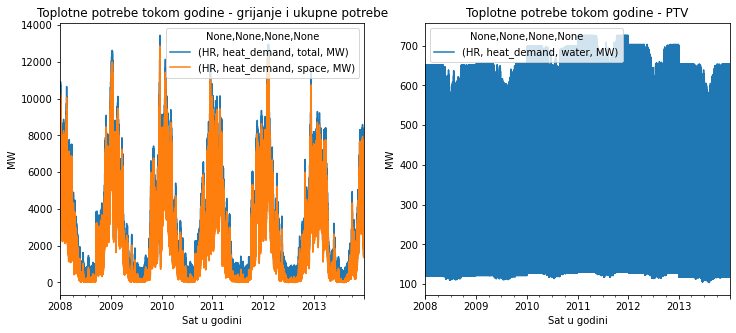

In [13]:
fig,ax=plt.subplots(ncols=2)
heat_demand=[('HR',  'heat_demand',         'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW')]
file[file["Year"]<2014].plot(x=('country',     'variable',     'attribute',        'unit'),y=heat_demand,figsize=(12,5),ax=ax[0])
ax[0].set_xlabel("Sat u godini")
ax[0].set_ylabel("MW")
ax[0].set_title("Toplotne potrebe tokom godine - grijanje i ukupne potrebe")


water_demand=[(     'HR',  'heat_demand',         'water',          'MW')]
file[file["Year"]<2014].plot(x=('country',     'variable',     'attribute',        'unit'),y=water_demand,figsize=(12,5),ax=ax[1])
ax[1].set_xlabel("Sat u godini")
ax[1].set_ylabel("MW")
ax[1].set_title("Toplotne potrebe tokom godine - PTV")
plt.show()

In [14]:


file=file[(file["Year"]>2007)&(file["Year"]<2014)]

yearly_demand=file.groupby("Year")[[(     'HR',  'heat_demand',     'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW'),(     'HR',  'heat_demand',         'water',          'MW')]].sum()/1000000
col_demand_heat=[(     'HR',  'heat_demand',     'space_COM',          'MW'),
            (     'HR',  'heat_demand',     'space_MFH',          'MW'),
            (     'HR',  'heat_demand',     'space_SFH',          'MW')]

#yearly_demand=file.groupby("Year")[('HR',  'heat_demand',         'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW'),(     'HR',  'heat_demand',         'water',          'MW')].sum()
#col_demand_heat=[(     'HR',  'heat_demand',     'space_COM',          'MW'),
            #(     'HR',  'heat_demand',     'space_MFH',          'MW'),
           # (     'HR',  'heat_demand',     'space_SFH',          'MW')]
heat_space=file.groupby("Year")[col_demand_heat].sum()/1000000

Najveći udio u godišnjim potrebama za grijanje čine individualni objekti. Napomena: legenda na dijagramima je u MW jer je to dio imena kolona koja će se naknadno promijeniti. Odgovrajuće vrijednosti su u TW, kako je naznačeno na y-osi. Najanje toplotne potrebe su za zgrade uslužnih djelatnosti.

Text(0.5, 1.0, 'Godišnje toplotne potrebe u TW')

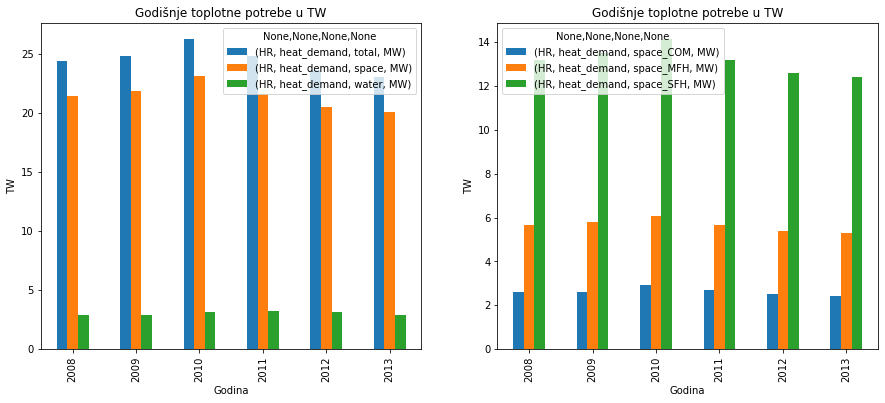

In [15]:
fig,ax=plt.subplots(ncols=2,figsize=(15,6))
yearly_demand.plot.bar(ax=ax[0])
ax[0].set_xlabel("Godina")
ax[0].set_ylabel("TW")
ax[0].set_title("Godišnje toplotne potrebe u TW")

heat_space.plot.bar(ax=ax[1])
ax[1].set_xlabel("Godina")
ax[1].set_ylabel("TW")
ax[1].set_title("Godišnje toplotne potrebe u TW")


Ukupno toplotno opterećnje veće od 6000 MW traje oko 1500 sati godišnje.

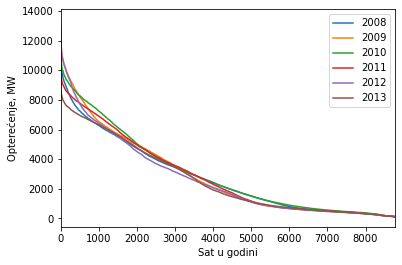

<Figure size 1440x720 with 0 Axes>

In [16]:
years=[2008,2009,2010,2011,2012,2013]
ax=plt.gca()
fig=plt.figure(figsize=(20,10))
for i,year in enumerate(years):
    duration_curve=file[file["Year"]==year]
    duration_curve=duration_curve.sort_values(by=(     'HR',  'heat_demand',         'total',          'MW'), ascending=False)
    ax.plot(np.arange(len(duration_curve)),duration_curve[(     'HR',  'heat_demand',         'total',          'MW')],label=year,)
   
    ax.legend()
    ax.set_xlabel("Sat u godini")
    ax.set_ylabel("Opterećenje, MW")
    ax.margins(x=0)
    ax.set_xticks(np.arange(0,9000,1000))
plt.show() 

Prosječni dnevni profil grijnih potreba je dat na sljedećem dijagramu za sve tipove objekata. Vršno opterećenje se dešava ujutru, kada startaju sistemi,te u poslijepodnevnim satima kada ljudi borave u stambenim objektima.Potrebe objekata uslužnih djelatnosti su znatno manje od potreba zagrijavanja stambenih objekata, te se u tom slučaju bilježi značajan pad za stambene objekte u periodu od 5 do 11h. Sličan trend se bilježi i kod potrošnje PTV. Srednje vršno opterećenje za grijanje iznosi 2000 MW, a u slučaju PTV nešto više od 600 MW.

C:\Users\Ehlimana\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


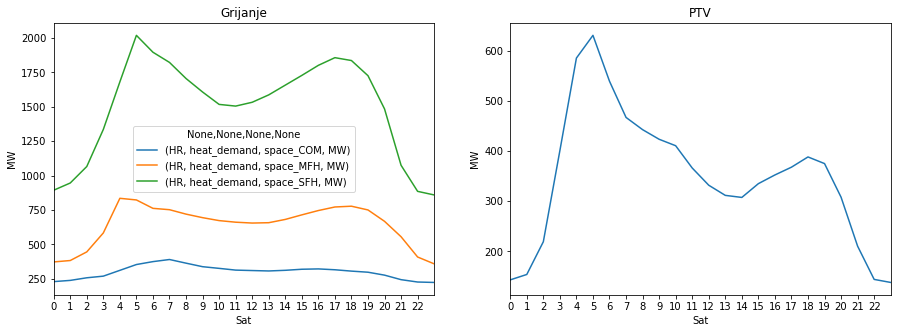

In [17]:
fig,ax=plt.subplots(ncols=2,figsize=(15,5))

file.groupby("Hour")[col_demand_heat].mean().plot.line(ax=ax[0])
ax[0].margins(x=0)
ax[0].set_xticks(np.arange(0,23,1))
ax[0].set_ylabel("MW")
ax[0].set_xlabel("Sat")
ax[0].set_title("Grijanje")

file.groupby("Hour").mean()[(     'HR',  'heat_demand',         'water',          'MW')].plot.line(ax=ax[1])
ax[1].margins(x=0)
ax[1].set_xticks(np.arange(0,23,1))
ax[1].set_ylabel("MW")
ax[1].set_xlabel("Sat")
ax[1].set_title("PTV")
plt.show()

In [18]:
#file.plot(x=('country',     'variable',     'attribute',        'unit'),y=[(                  'HR', 'heat_profile', 'space_COM', 'MW/TWh'),
          #  (                  'HR', 'heat_profile', 'space_MFH', 'MW/TWh'),
          #  (                  'HR', 'heat_profile', 'space_SFH', 'MW/TWh')],figsize=(15,8))

Ovaj dobijeni toplotni profil će se uporediti na sa jednomjesečnim uzorkom dobivenim sa jedne od grana koju snabdijevaju Toplane Sarajevo. Za detaljnije ispitivanje razlika, mogle bi se primijeniti statističke metode da se utvrdi da li postoji značajna razlika ili ne, ili da se izračuna razlika dvije populacije, međutim, možda to u ovom trenutku nije značajno.


In [19]:
#Kopiran kod iz fajla Kotlovnica.ipynb

filex=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet1",header=0)
filex1=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet2",header=None)

filex2=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet3",header=None)
filex3=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet4",header=None)
filex1=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet2",header=None)

filex2=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet3",header=None)
filex3=pd.read_excel(r"FILES\HEAT\Podvožnjak.xlsx",sheet_name="Sheet4",header=None)


def create_date_range(start,end):
    date_range=pd.date_range(start,end,freq="1H").strftime("%m-%d-%Y, %H:%M")[::-1]
    return date_range


date_range=create_date_range("2021-12-04 16:00","2022-01-06 11:00")
date_range1=create_date_range("2021-12-04 16:00","2022-01-06 12:00")
date_range2=create_date_range("2021-12-04 16:00","2022-01-06 12:00")
date_range3=create_date_range("2021-12-04 16:00","2022-01-06 12:00")

def set_index1(data,date_range):
    data=data.set_index(date_range)
    return data

filex=set_index1(filex,date_range)
filex1=set_index1(filex1,date_range1)
filex2=set_index1(filex2,date_range2)
filex3=set_index1(filex3,date_range3)


filex.columns=[ "Index", "Datum","Kumrovec-Potrošnja, MWh"]
filex1.columns=[ "Index", "Datum","oko kotlovnice-Potrošnja, MWh"]
filex2.columns=[ "Index", "Datum","niz uz Vranica-Potrošnja, MWh"]
filex3.columns=[ "Index", "Datum","Vranica-Potrošnja, MWh"]

def assign_date_properties(file):
    file=file.assign(Sat=pd.to_datetime(file.index).hour)
    file=file.assign(Mjesec=pd.to_datetime(file.index).month)#format dana i mjeseca zamijenjen
    file=file.assign(Dan=pd.to_datetime(file.index).day)
    file=file.assign(Dan_u_sedmici=pd.to_datetime(file.index).dayofweek)
    return file


filex=assign_date_properties(filex)
filex1=assign_date_properties(filex1)
filex2=assign_date_properties(filex2)
filex3=assign_date_properties(filex3)

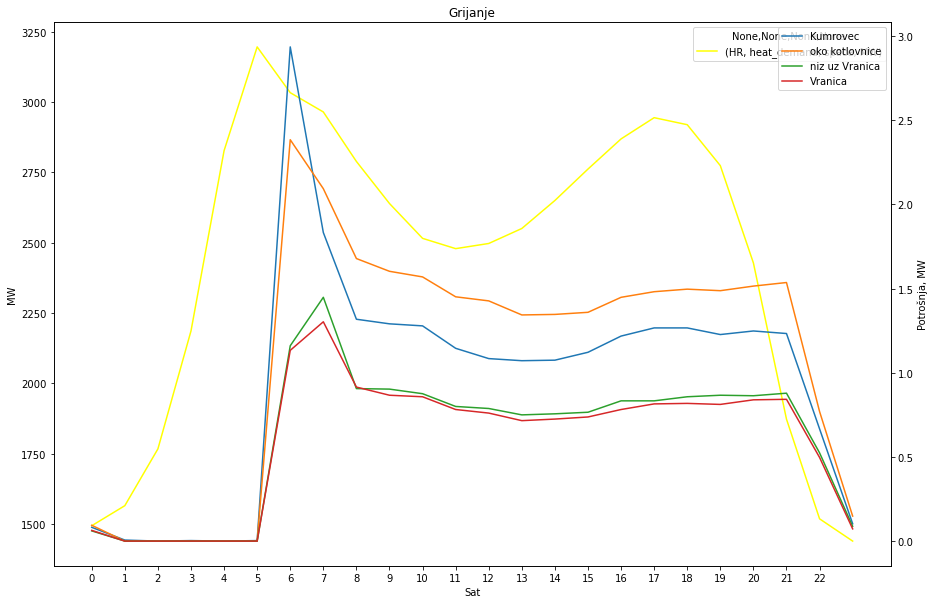

In [20]:

ax=plt.gca()
file.groupby("Hour")[[(        'HR',  'heat_demand',     'space',     'MW')]].mean().plot.line(ax=ax,figsize=(15,10),color="yellow")
ax.margins(x=0)
ax.set_xticks(np.arange(0,23,1))
ax.set_ylabel("MW")
ax.set_xlabel("Sat")
ax.set_title("Grijanje")

ax_1=ax.twinx()

filexy=filex.groupby("Sat")["Kumrovec-Potrošnja, MWh"].mean().plot(ax=ax_1,label="Kumrovec")
filex1=filex1.groupby("Sat")["oko kotlovnice-Potrošnja, MWh"].mean().plot(ax=ax_1,label="oko kotlovnice")
filex2=filex2.groupby("Sat")["niz uz Vranica-Potrošnja, MWh"].mean().plot(ax=ax_1,label="niz uz Vranica")
filex3=filex3.groupby("Sat")["Vranica-Potrošnja, MWh"].mean().plot(ax=ax_1,label="Vranica")
ax_1.set_ylabel("Potrošnja, MW")
ax_1.legend()



Iz iste baze podataka je moguće izvući temperaturu zraka, direktno i difuzno Sunčevo zračenje. Trenutna analiza će se odnositi samo na temperaturu zraka. Ovi podaci su dostupni u satnoj rezoluciji od 1980 - 2018.

In [21]:
#kopirati weather_data u FILES\HEAT
file_weather=pd.read_csv(r"FILES\HEAT\weather_data.csv",parse_dates=True,header=0)

In [22]:
file_weather.columns[(file_weather.columns.str.contains("HR"))]

Index(['HR_temperature', 'HR_radiation_direct_horizontal',
       'HR_radiation_diffuse_horizontal'],
      dtype='object')

In [23]:
col_HR=file_weather[file_weather.columns[(file_weather.columns.str.contains("HR"))|(file_weather.columns.str.contains("utc_timestamp"))]]

In [24]:
col_HR.head(3)

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal
0,1980-01-01T00:00:00Z,-0.880,0.0,0.0
1,1980-01-01T01:00:00Z,-0.888,0.0,0.0
2,1980-01-01T02:00:00Z,-0.950,0.0,0.0


Za ovaj fajl je potrebno prilagoditi format datuma kako bi se iz njega dobile korisne informacije.

In [25]:
pd.set_option('mode.chained_assignment', None)

In [26]:
d=[]

from datetime import datetime
for value1 in col_HR.iloc[:,0]:
    value1=value1.replace('Z', '')
    value1=datetime.fromisoformat(value1)
    value1.strftime('%Y-%m-%d %H:%M:%S')
    d.append(value1)

In [27]:
col_HR.iloc[:,0]=d

In [28]:
col_HR.iloc[:,0]=pd.to_datetime(col_HR.iloc[:,0],utc=True)

In [29]:
col_HR.head()

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal
0,1980-01-01 00:00:00+00:00,-0.880,0.0,0.0
1,1980-01-01 01:00:00+00:00,-0.888,0.0,0.0
2,1980-01-01 02:00:00+00:00,-0.950,0.0,0.0
3,1980-01-01 03:00:00+00:00,-1.157,0.0,0.0
4,1980-01-01 04:00:00+00:00,-1.468,0.0,0.0


In [30]:
pd.set_option('mode.chained_assignment', None)

In [31]:
col_HR["Year"]=col_HR.iloc[:,0].dt.year
col_HR["Month"]=col_HR.iloc[:,0].dt.month
col_HR["Dayofyear"]=col_HR.iloc[:,0].dt.dayofyear
col_HR["Dayofmonth"]=col_HR.iloc[:,0].dt.day
col_HR["Hour"]=col_HR.iloc[:,0].dt.hour

In [32]:
col_HR.head(3)

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal,Year,Month,Dayofyear,Dayofmonth,Hour
0,1980-01-01 00:00:00+00:00,-0.880,0.0,0.0,1980,1,1,1,0
1,1980-01-01 01:00:00+00:00,-0.888,0.0,0.0,1980,1,1,1,1
2,1980-01-01 02:00:00+00:00,-0.950,0.0,0.0,1980,1,1,1,2


Za temperaturu zraka će se odabrati podaci od 2008. do 2013. jer su u tom periodu dostupne toplotne potrebe.

In [33]:
col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2013)].head(3)

,utc_timestamp,HR_temperature,HR_radiation_direct_horizontal,HR_radiation_diffuse_horizontal,Year,Month,Dayofyear,Dayofmonth,Hour
245448,2008-01-01 00:00:00+00:00,-4.649,0.0,0.0,2008,1,1,1,0
245449,2008-01-01 01:00:00+00:00,-4.793,0.0,0.0,2008,1,1,1,1
245450,2008-01-01 02:00:00+00:00,-4.924,0.0,0.0,2008,1,1,1,2


Sa narednog dijagrama se može vidjeti očekivani pad toplotnih potreba sa porastom temperature zraka i obrnuto, te će se kasnije prikazati i negativna korelacija.

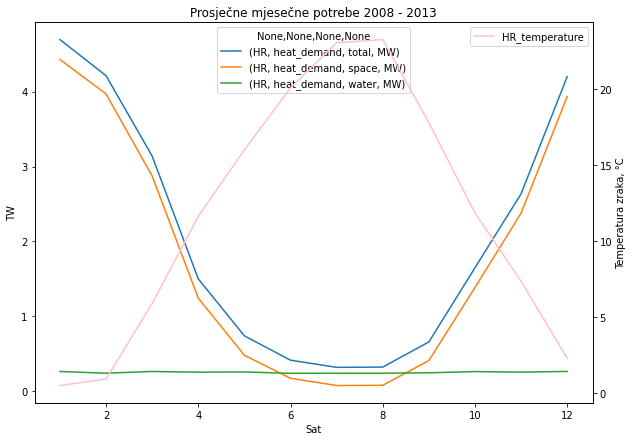

In [34]:
years=col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2013)]
ax=plt.gca()

cols_total=[('HR',  'heat_demand',         'total',          'MW'),(     'HR',  'heat_demand',         'space',          'MW'),(     'HR',  'heat_demand',         'water',          'MW')]

plot_file=file.groupby(["Month","Year"])[cols_total].sum()

(plot_file.groupby(["Month"])[cols_total].mean()/1000000).plot(kind="line",ax=ax,figsize=(10,7))
ax_1=ax.twinx()

years[(years["Year"]>=2008)&(years["Year"]<=2013)].groupby("Month")["HR_temperature"].mean().plot(kind="line",ax=ax_1,color="pink")
ax.set_xlabel("Sat")
ax.set_ylabel("TW")
ax.set_title("Prosječne mjesečne potrebe 2008 - 2013")
ax_1.set_ylabel("Temperatura zraka, °C")
ax_1.legend()
plt.show()

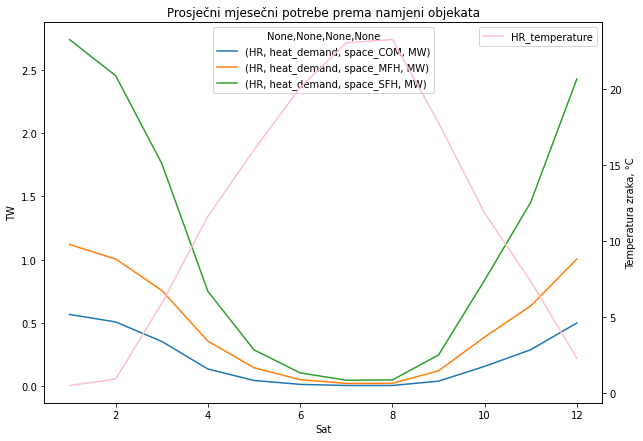

In [35]:
years=col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2013)]
ax=plt.gca()
plot_file=file.groupby(["Month","Year"])[col_demand_heat].sum()
(plot_file.groupby("Month").mean()/1000000).plot(kind="line",ax=ax,figsize=(10,7))
ax_1=ax.twinx()

years[(years["Year"]>=2008)&(years["Year"]<=2013)].groupby("Month")["HR_temperature"].mean().plot(kind="line",ax=ax_1,color="pink")
ax.set_xlabel("Sat")
ax.set_ylabel("TW")
ax.set_title("Prosječni mjesečni potrebe prema namjeni objekata")
ax_1.set_ylabel("Temperatura zraka, °C")
ax_1.legend()
plt.show()

In [36]:
cols=cols_total+col_demand_heat

heat_0818=file[cols].reset_index()
col_HR_0818=col_HR[(col_HR["Year"]>=2008)&(col_HR["Year"]<=2018)][["utc_timestamp","HR_temperature","Year","Month"]].reset_index()
years1=pd.concat([heat_0818,col_HR_0818],axis=1)
years1=years1.dropna()

In [37]:
years1.head(2)

,"(index, , , )","(HR, heat_demand, total, MW)","(HR, heat_demand, space, MW)","(HR, heat_demand, water, MW)","(HR, heat_demand, space_COM, MW)","(HR, heat_demand, space_MFH, MW)","(HR, heat_demand, space_SFH, MW)",index,utc_timestamp,HR_temperature,Year,Month
0,2.0,5377.0,5235.0,142.0,808.0,1211.0,3217.0,245448,2008-01-01 00:00:00+00:00,-4.649,2008,1
1,3.0,5516.0,5376.0,140.0,824.0,1231.0,3321.0,245449,2008-01-01 01:00:00+00:00,-4.793,2008,1


Minimalne potrbebe za grijanjem prostora su zabilježene pri temperaturama od oko 23- 24°C, a  maksimalne pri temperaturama nižim od -10°C.

In [38]:
for k,col in enumerate(cols):
    print(years1[years1[col]==years1[col].min()].iloc[:,[8,k+1,9]])

                  utc_timestamp  (HR, heat_demand, total, MW)  HR_temperature
49078 2013-08-06 22:00:00+00:00                         106.0          24.623
49102 2013-08-07 22:00:00+00:00                         106.0          24.571
                  utc_timestamp  (HR, heat_demand, space, MW)  HR_temperature
49102 2013-08-07 22:00:00+00:00                           2.0          24.571
49103 2013-08-07 23:00:00+00:00                           2.0          23.991
49104 2013-08-08 00:00:00+00:00                           2.0          23.456
                  utc_timestamp  (HR, heat_demand, water, MW)  HR_temperature
49054 2013-08-05 22:00:00+00:00                         104.0          23.781
49078 2013-08-06 22:00:00+00:00                         104.0          24.623
49102 2013-08-07 22:00:00+00:00                         104.0          24.571
                  utc_timestamp  (HR, heat_demand, space_COM, MW)  \
3243  2008-05-15 03:00:00+00:00                               1.0   
3267

In [39]:
for k,col in enumerate(cols):
   
    print(years1[years1[col]==years1[col].max()].iloc[:,[8,k+1,9]])

                  utc_timestamp  (HR, heat_demand, total, MW)  HR_temperature
17261 2009-12-20 05:00:00+00:00                       13450.0         -11.066
                  utc_timestamp  (HR, heat_demand, space, MW)  HR_temperature
17261 2009-12-20 05:00:00+00:00                       12869.0         -11.066
                  utc_timestamp  (HR, heat_demand, water, MW)  HR_temperature
26381 2011-01-04 05:00:00+00:00                         726.0          -5.767
26429 2011-01-06 05:00:00+00:00                         726.0          -4.038
26549 2011-01-11 05:00:00+00:00                         726.0           2.994
26597 2011-01-13 05:00:00+00:00                         726.0           1.051
26717 2011-01-18 05:00:00+00:00                         726.0           1.907
26765 2011-01-20 05:00:00+00:00                         726.0           0.271
26885 2011-01-25 05:00:00+00:00                         726.0          -6.771
26933 2011-01-27 05:00:00+00:00                         726.0   

Pearsonov koeficijent korelacije kao mjera linearne veze ukazuje na negativnu zavisnost. Nizak koeficijent korelacije je u slučaju potreba za PTV jer su one manje podložne sezonskim promjenama.

In [40]:
for col in cols:
    print(col,"Temperature correlation:")
    print(years1["HR_temperature"].corr(years1[col]))

('HR', 'heat_demand', 'total', 'MW') Temperature correlation:
-0.8258342154752158
('HR', 'heat_demand', 'space', 'MW') Temperature correlation:
-0.8358638272423864
('HR', 'heat_demand', 'water', 'MW') Temperature correlation:
-0.04568713562505972
('HR', 'heat_demand', 'space_COM', 'MW') Temperature correlation:
-0.8430491780555925
('HR', 'heat_demand', 'space_MFH', 'MW') Temperature correlation:
-0.8408678783670563
('HR', 'heat_demand', 'space_SFH', 'MW') Temperature correlation:
-0.8283760272030392


Normalizirane vrijednosti trenutnih naspram ukupnih godišnjih potreba za svaku godinu u periodu 2008 - 2013 će se ponovo izračunati i spasiti u obliku MW/TWh (scaled_columns)

In [41]:
#scaled_factors=pd.DataFrame()

scaled_columns=["total_heat_demand_MW/TWh","space_heat_demand_MW/TWh","water_heat_demand_MW/TWh","space_COM_demand_MW/TWh",
               "space_MFH_demand_MW/TWh","space_SFH_demand_MW/TWh"]


years1=years1.assign(**dict([(_,None) for _ in scaled_columns]))
years_list=[2008,2009,2010,2011,2012,2013]
for year in years_list:
    sum_year=years1[years1["Year"]==year][cols].sum(axis=0)
    
    years1.loc[years1["Year"]==year,scaled_columns]=(years1[years1["Year"]==year][cols].div(sum_year/1000000)).astype(float).values
   
    years1.loc[years1["Year"]==year,"Hourofyear"]=np.arange(len(years1[years1["Year"]==year]))
    
years1[scaled_columns]=years1[scaled_columns].astype(float)

## Opcija 1: Toplotne potrebe - BiH

Iz Tipologije stambenih zgrada i Tipologije javnih objekata (biće navedena referenca) pronađeni su podaci o procijenjenim godišnjim potrebama za grijanjem prostora u BiH, s tim da javne zgrade ne odgovaraju svim zgradama uslužnih djelatnosti, ali je jedini poznat podatak. Također, ovdje nisu uključene toplotne potrebe za PTV, već se one odnose samo na grijanje prostora. Nadalje, potrebno je dodatno sagledati energetski bilans BiH za 2019./2020. i 2021.

In [42]:
BH_demand=years1.groupby("Hourofyear")[scaled_columns].mean()

In [43]:
# Bosnia - residential buildings #annually - source: typology of residential buildings 19593880 mwh/god #arbitrary year

SFH=(16698261+369706)/1000000, 
MFH=(960738+197893+1274382+92900)/1000000
COM=1683423/1000000

Sada će se iskoristiti normalizirani podaci Hrvatske i pomnožit će se sa ukupnim godišnjim potrebama za dati tip objekata u BiH kako bi se dobile trenutne potrebe za grijanjem.Ovo je obrnut proces u odnosu na način na koji su se dobile normalizirane vrijednosti.

In [44]:
space_heat_scaled=['space_COM_demand_MW/TWh',
       'space_MFH_demand_MW/TWh', 'space_SFH_demand_MW/TWh']

BH_demand["heat_demand, space_COM, MW"]=BH_demand['space_COM_demand_MW/TWh']*COM
BH_demand["heat_demand, space_MFH, MW"]=BH_demand['space_MFH_demand_MW/TWh']*MFH
BH_demand["heat_demand, space_SFH, MW"]=BH_demand['space_SFH_demand_MW/TWh']*SFH

BH_demand['heat_demand', 'space', 'MW']=BH_demand["heat_demand, space_COM, MW"]+BH_demand["heat_demand, space_MFH, MW"]+BH_demand["heat_demand, space_SFH, MW"]

In [45]:
BH_demand.head(2)

,total_heat_demand_MW/TWh,space_heat_demand_MW/TWh,water_heat_demand_MW/TWh,space_COM_demand_MW/TWh,space_MFH_demand_MW/TWh,space_SFH_demand_MW/TWh,"heat_demand, space_COM, MW","heat_demand, space_MFH, MW","heat_demand, space_SFH, MW","(heat_demand, space, MW)"
Hourofyear,,,,,,,,,,
0.0,177.587680,195.978876,48.784742,241.659163,177.748360,194.729872,406.814593,448.976892,3323.643033,4179.434518
1.0,181.742356,200.976037,47.157290,245.085555,179.657618,201.355110,412.582660,453.799514,3436.722381,4303.104555


Text(0.5, 1.0, 'Godišnje potrebe BiH - javni i stambeni objekti ')

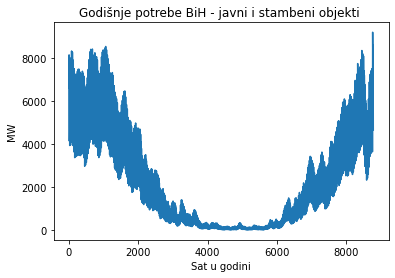

In [46]:
BH_demand['heat_demand', 'space', 'MW'].plot()
plt.xlabel("Sat u godini")
plt.ylabel("MW")
plt.title("Godišnje potrebe BiH - javni i stambeni objekti ")

## Opcija 2: Demandlib biblioteka

Istraživanjem seta podataka when2heat, od istih autora je pronađena Python biblioteka koja radi na sličnom principu kao i proračun koji je izvršen za 16 zemalja.  Osnova su podaci o distribuciji gasa u Njemačkoj, s tim da se kao ulaz koriste još i praznici, te da li je područje vjetrovito ili ne. Zasad će se istraživanje bazirati samo na unos praznika za 2019. i toplotnih potreba po objektima za BiH koje su prethodno navedene. U budućnosti se mogu klimatski podaci preuzeti i sa websitea NASA-e, slično kao za vjetroelektrane - za nekoliko područja u BiH, te izračunati prosječne vrijednosti brzine vjetra na visini od 10 m. Trenutno su se iskoristili podaci dobiveni za 2018. godinu od FHMZ za Sarajevo (temperatura zraka - podaci u fajlu example_data.csv).

In [47]:
#%pip install demandlib

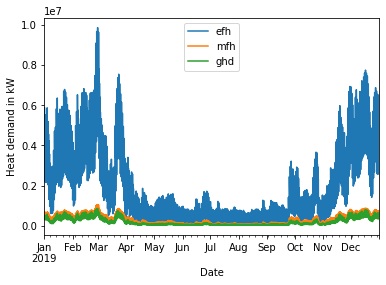

Annual consumption: 
efh    1.724586e+10
mfh    2.552098e+09
ghd    1.700957e+09
dtype: float64
                              efh            mfh            ghd
2019-01-01 00:00:00  2.322498e+06  325098.663214  324516.121166
2019-01-01 01:00:00  2.373654e+06  345674.527974  319743.825266
2019-01-01 02:00:00  2.455504e+06  349789.700926  363648.947542
2019-01-01 03:00:00  2.649899e+06  375852.462956  440960.141114
2019-01-01 04:00:00  3.243312e+06  467757.992219  523998.089765
...                           ...            ...            ...
2019-12-31 19:00:00  5.705155e+06  721751.194787  461533.424185
2019-12-31 20:00:00  5.434018e+06  705581.616085  431458.564464
2019-12-31 21:00:00  4.801368e+06  643843.224678  378249.197265
2019-12-31 22:00:00  3.389201e+06  561525.369468  344704.161422
2019-12-31 23:00:00  2.711361e+06  413059.237750  347017.612169

[8760 rows x 3 columns]


In [48]:
#KOD SA BIBLIOTEKE

# -*- coding: utf-8 -*-
"""
Creating heat demand profiles using the bdew method.
Installation requirements
-------------------------
This example requires at least version v0.1.4 of the oemof demandlib. Install
by:
    pip install 'demandlib>=0.1.4,<0.2'
Optional:
    pip install matplotlib
SPDX-FileCopyrightText: Birgit Schachler
SPDX-FileCopyrightText: Uwe Krien <krien@uni-bremen.de>
SPDX-FileCopyrightText: jnnr
SPDX-FileCopyrightText: Stephen Bosch
SPDX-License-Identifier: MIT
"""
import datetime
import os

import demandlib.bdew as bdew

# read example temperature series
filename = 'AUXILLIARY\example_data.csv'
dirname = os.getcwd()
datapath = os.path.join(dirname, filename)

if not os.path.isfile(datapath):
    msg = (
        "The file {0} could not be found in the current working directory.\n "
        "This could happen due to the following reasons:\n"
        "* you forgot to download the example data from the repository\n"
        "* the filename is wrong\n"
        "* the file is not located in {1}\n"
        "Download the file from the demandlib repository and copy it to the "
        "right directory.\nAlternatively you can adapt the name of the file "
        "or the name of the directory in the example script."
    )
    print(msg.format(filename, dirname))
    exit(0)

temperature = pd.read_csv(datapath)["temperature"]


# The following dictionary is create by "workalendar"
# pip3 install workalendar
# >>> from workalendar.europe import Germany
# >>> cal = Germany()
# >>> holidays = dict(cal.holidays(2010))


ann_demands_per_type = {"efh": (16698261+369706)*1000*8760/8670, "mfh": (960738+197893+1274382+92900)*1000*8760/8670, "ghd": 1683423*1000*8760/8670}

holidays = {
   
  
    datetime.date(2019, 1, 1): "New year",
    datetime.date(2019, 1, 2): "New year",
    datetime.date(2019, 1, 7): "Christmas Day",
    datetime.date(2019, 12, 25): "Christmas Day",
    datetime.date(2019, 4, 21): "Easter",
    datetime.date(2019, 4, 28): "Easter",

    datetime.date(2019, 5, 1): "Labour Day",
    datetime.date(2019, 5, 2): "Labour Day",
    datetime.date(2019, 6, 4): "Eid",
    datetime.date(2019, 8, 11): "Eid",
    
    datetime.date(2019, 11, 25): "Statehood",
    datetime.date(2019, 3, 1): "Independence",
    
}

# Create DataFrame for 2019
demand = pd.DataFrame(
    index=pd.date_range(
        datetime.datetime(2019, 1, 1, 0), periods=8760, freq="H"
    )
)

# Single family house (efh: Einfamilienhaus)
demand["efh"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="EFH",
    building_class=1,
    wind_class=1,
    annual_heat_demand=ann_demands_per_type["efh"],
    name="EFH",
).get_bdew_profile()

# Multi family house (mfh: Mehrfamilienhaus)
demand["mfh"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="MFH",
    building_class=2,
    wind_class=0,
    annual_heat_demand=ann_demands_per_type["mfh"],
    name="MFH",
).get_bdew_profile()

# Industry, trade, service (ghd: Gewerbe, Handel, Dienstleistung)
demand["ghd"] = bdew.HeatBuilding(
    demand.index,
    holidays=holidays,
    temperature=temperature,
    shlp_type="ghd",
    wind_class=0,
    annual_heat_demand=ann_demands_per_type["ghd"],
    name="ghd",
).get_bdew_profile()

# Plot demand of building
ax = demand.plot()
ax.set_xlabel("Date")
ax.set_ylabel("Heat demand in kW")
plt.show()

print("Annual consumption: \n{}".format(demand.sum()))

print(demand)

for key in ann_demands_per_type:
    assert np.isclose(demand[key].sum(), ann_demands_per_type[key], rtol=1e-4)

## Opcija 3: Predviđanje na osnovu temperature

Opcija 3 se odnosi na korištenje podataka o temperaturi zraka kako bi se napravio model koji na osnovu temperature zraka predviđa potrebe za toplotom. Kada bi se podaci iz Hrvatske normalizirali i posmatrali u ovisnosti od temperature, stvorio bi se referentni model. Nakon toga bi se unosom temperature zraka iz 2019, 2020, ili 2021. vršilo predviđanje potreba, s tim da je upitno koliko bi taj model bio drugačiji od Opcije 1 jer su osim temperature zraka bitne i mjere energetske efikanosti koje su se provele u međuvremenu. Nakon toga bi se ponovio postupak za dobijanje toplotnih potreba BiH. Za sada ova opcija može biti samo u domeni potencijalnog istraživanja jer treba uraditi statističku pripremu podataka u vidu autokorelacije, dodavanja dodatnih nezavisnih i sl.

In [49]:
coltemp=['HR_temperature']+scaled_columns

In [50]:
print(coltemp)

['HR_temperature', 'total_heat_demand_MW/TWh', 'space_heat_demand_MW/TWh', 'water_heat_demand_MW/TWh', 'space_COM_demand_MW/TWh', 'space_MFH_demand_MW/TWh', 'space_SFH_demand_MW/TWh']


In [51]:
train_size = int(0.85 * len(years1))
test_size = len(years1) - train_size
coltemp=['HR_temperature']+scaled_columns
univariate_df = years1[coltemp].copy()
#univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1:])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1:])

print(len(train), len(x_valid))

44716 7892


In [52]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor

In [53]:
model=MultiOutputRegressor(AdaBoostRegressor(random_state=0, n_estimators=10000)).fit(x_train,y_train)
print(model.score(x_train,y_train))

0.6461143110564211


In [54]:
y_pred=model.predict(x_valid)

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
#%pip install xgboost

In [56]:
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 50.786789495569515


In [57]:
y_pred[5]

array([193.24642119, 206.13712136, 120.02435454, 223.09258599,
       203.36675483, 214.75540975])

# Priprema fajlova za EnergyPLAN

Da bi se primijenila biblioteka demand_lib, prvo će se sa portala https://power.larc.nasa.gov/data-access-viewer/ preuzeti brzine vjetra na 10 m/s za nekoliko gradova iz različitih regija BiH. Na osnovu toga će se izračunati srednja brzina vjetra i provjeriti da li je ona iznad ili ispod 4.4 m/s za datu godinu.

In [58]:
wind_speed=pd.read_excel(r"FILES\VJETAR\Wind_speed.xlsx",header=0)

In [59]:
wind_speed.head()

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
0,2019,1,1,0,3.53,2.01,2.28,6.61,1.87,6.46,3.22,8.57
1,2019,1,1,1,3.70,2.10,2.20,6.43,1.59,6.19,3.25,8.62
2,2019,1,1,2,3.69,2.21,2.06,6.14,1.16,6.10,3.41,8.80
3,2019,1,1,3,3.62,2.03,1.78,5.92,0.71,6.10,3.28,8.89
4,2019,1,1,4,3.61,1.63,1.43,6.01,0.44,6.50,3.12,8.78


In [60]:
average_by_hour_2019=wind_speed[wind_speed["YEAR"]==2019][wind_speed.columns[4:]].mean(axis=1)
average_by_hour_2020=wind_speed[wind_speed["YEAR"]==2020][wind_speed.columns[4:]].mean(axis=1)
average_by_hour_2021=wind_speed[wind_speed["YEAR"]==2021][wind_speed.columns[4:]].mean(axis=1)

Za svaku od razmatranih godina brzina vjetra je manja od 4.4 m/s. U prvobitnoj namjeri je uzeto više gradova ali su za neke podaci bili identični, te su onda duplikati izbrisani.

In [61]:
average_by_2019=average_by_hour_2019.mean()
average_by_2020=average_by_hour_2020.mean()
average_by_2021=average_by_hour_2021.mean()
print("Prosječna brzina vjetra u 2019.:",average_by_2019)
print("Prosječna brzina vjetra u 2020.:",average_by_2020)
print("Prosječna brzina vjetra u 2021.:",average_by_2021)

Prosječna brzina vjetra u 2019.: 2.775359589041096
Prosječna brzina vjetra u 2020.: 2.718379012978148
Prosječna brzina vjetra u 2021.: 2.7185901826484224


Za demand_lib je potrebna i satna distribucija temperature u BiH, pa će se i ona uzeti kao prosječna satna vrijednost za prethodno navedene gradove. Međutim, prije toga će se pokušati izvršiti validacija podataka sa navedenog portala jer je FHMZ dostavio satne temperature za 2018. i polovinu 2019. za Sarajevo, te će se podaci za 2018. uporediti sa podacima za 2018 sa portala NASAe.

Podaci od FHMZ su specifično uređeni te ih je potrebno modifikovati u oblik jednostavan za računanje.

In [62]:
file2=pd.read_excel(r"AUXILLIARY\satne_temp.xls",header=1) #FHMZ 

In [63]:
file2.columns #metrološka stanica sarajevo

Index([ 'Year', 'Month',  'Time',       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,      13,
            14,      15,      16,      17,      18,      19,      20,      21,
            22,      23,      24,      25,      26,      27,      28,      29,
            30,      31],
      dtype='object')

In [64]:
file2.loc[147,24]=(4.2+8.3)/2 # popunjavanje anomalije

In [65]:
months_2018=file2["Month"].unique()

In [66]:
months_2018=sorted(months_2018) #sortiranje po mjesecima jer u originalnom fajlu nisu sortirani podaci

In [67]:
df=[None]*12
for k,month in enumerate(months_2018):
    year=file2[file2["Year"]==2018]
    month_file=year[year["Month"]==month]
    days=np.array(len(month_file.columns[3:]))
    df[k]=month_file[month_file.columns[3:]].values.flatten("F")

In [68]:
df[0].shape

(744,)

In [69]:

arr = np.concatenate(df)

In [70]:
len(arr)

8928

In [71]:
output1 = arr[np.isfinite(arr)]

In [72]:
len(output1)

8760

In [73]:
output1=pd.DataFrame(output1,columns=["temperature"]) #spašavanje u dataframe

Otvaranje fajla sa NASA-inog portala:

In [74]:
test_temp=pd.read_excel(r"AUXILLIARY\Sa_2018_NASA.xlsx",header=0,usecols="E")

<AxesSubplot:>

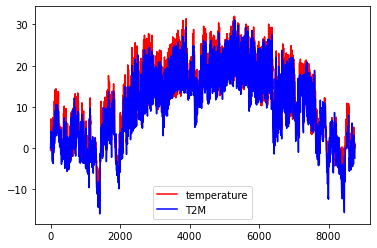

In [75]:
ax=plt.gca()
output1.plot(color="red",ax=ax)
test_temp.plot(color="blue",ax=ax)

In [76]:
#Ovaj dio će se nastaviti i računat će se razlika između dvije populacije....

Temperature za pojedine gradove su date u sljedećem fajlu:

In [77]:
temp_cities=pd.read_excel(r"AUXILLIARY\Temp_cities.xlsx",header=0,)

In [78]:
temp_cities.head()

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
0,2019,1,1,0,-2.47,-0.10,-0.51,-3.36,-3.88,-1.92,0.61,8.50
1,2019,1,1,1,-2.49,-0.22,-0.57,-3.36,-3.61,-2.13,-0.23,8.44
2,2019,1,1,2,-2.47,-0.39,-0.73,-3.35,-3.14,-2.24,-0.81,8.35
3,2019,1,1,3,-2.52,-0.82,-1.12,-3.31,-2.64,-2.36,-1.52,8.28
4,2019,1,1,4,-2.70,-1.63,-1.78,-3.41,-2.49,-2.46,-2.07,8.09


In [79]:
averaget_by_hour_2019=temp_cities[temp_cities["YEAR"]==2019][temp_cities.columns[4:]].mean(axis=1)
averaget_by_hour_2020=temp_cities[temp_cities["YEAR"]==2020][temp_cities.columns[4:]].mean(axis=1)
averaget_by_hour_2021=temp_cities[temp_cities["YEAR"]==2021][temp_cities.columns[4:]].mean(axis=1)

In [80]:
averaget_by_hour_2019 = {'timestep':np.arange(len(averaget_by_hour_2019)), 'temperature': averaget_by_hour_2019}
averaget_by_hour_2020 = {'timestep':np.arange(len(averaget_by_hour_2020)), 'temperature': averaget_by_hour_2020}
averaget_by_hour_2021 = {'timestep':np.arange(len(averaget_by_hour_2021)), 'temperature': averaget_by_hour_2021}

In [81]:
averaget_by_hour_2019=pd.DataFrame(averaget_by_hour_2019)
averaget_by_hour_2020=pd.DataFrame(averaget_by_hour_2020)
averaget_by_hour_2021=pd.DataFrame(averaget_by_hour_2021)

In [82]:
averaget_by_hour_2019.to_csv(r'FILES\HEAT\averaget_by_hour_2019.csv',index=False)
averaget_by_hour_2020.to_csv(r'FILES\HEAT\averaget_by_hour_2020.csv',index=False)
averaget_by_hour_2021.to_csv(r'FILES\HEAT\averaget_by_hour_2021.csv',index=False)

Za primjenu biblioteke demand_lib će se definisati praznici, te će se odrediti klasa objekta na osnovu (https://www.eko-netz.de/files/eko-netz/download/3.5_standardlastprofile_bgw_information_lastprofile.pdf strana 42 i 43 i https://demandlib.readthedocs.io/en/latest/bdew.html) i Tipologije javnih i Tipologije stambenih zgrada u BiH, odnosno na osnovu udjela objekata izgrađenih do 1980. i nakon 1980. u BiH. Prema Tipologiji stambenih objekata, udio bruto površine po starosti objekata je sljedeći:
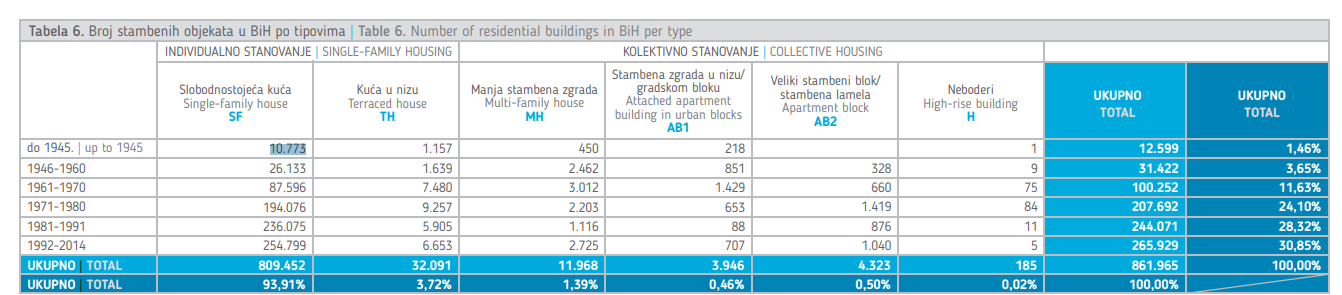         

In [83]:
#### stambeni objekti
print("SFH:")
print("do 1946:",((10.773+1157)/(809452+32091))*100,"%")
print("1946-1960:",((26133+1639)/(809452+32091))*100,"%")
print("1961-1970:",((87596+7480)/(809452+32091))*100,"%")
print("1971-1980:",((194076+9257)/(809452+32091))*100,"%")

print("SFH do 1980:",0.14+3.3+11.30+24.16,"%","\nKlasa:10")

print("\nMFH:")
print("do 1946:",((218+1)/(3946+4323+185))*100,"%")
print("1946-1960:",((851+328+9)/(3946+4323+185))*100,"%")
print("1961-1970:",((1429+660+75)/(3946+4323+185))*100,"%")
print("1971-1980:",((653+1410+84)/(3946+4323+185))*100,"%")
print("MFH do 1980:",2.59+14.05+25.60+25.40,"%", "\nKlasa: 5")

SFH:
do 1946: 0.13876569587056156 %
1946-1960: 3.300128454517476 %
1961-1970: 11.29781841213105 %
1971-1980: 24.16192636621064 %
SFH do 1980: 38.9 % 
Klasa:10

MFH:
do 1946: 2.5904897090134846 %
1946-1960: 14.052519517388218 %
1961-1970: 25.597350366690325 %
1971-1980: 25.396262124438135 %
MFH do 1980: 67.64 % 
Klasa: 5


In [84]:
#javni objekti

print("Javni objekti:")
print("do 1945:",(167/2156)*100,"%")
print("1946-1965:",(589/2156)*100,"%")
print("1966-1973:",(400/2156)*100,"%")
print("1974-1987:",(641/2156)*100,"%")

print("Javni objekti do 1980:",7.74+27.32+18.55+29.73/2,"%","\nKlasa:5")


Javni objekti:
do 1945: 7.745825602968461 %
1946-1965: 27.319109461966605 %
1966-1973: 18.552875695732837 %
1974-1987: 29.73098330241187 %
Javni objekti do 1980: 68.475 % 
Klasa:5


Procenat od 29.73% se odnosi na zgrade od 1974 do 1987, te se on prepolovio jer obuhvata veći period od 1974 - 1978. Bibiliotekom su odobrane tri kategorije objekata:

EFH: Einfamilienhaus (single family house)
MFH: Mehrfamilienhaus (multi family house)
GHD: Summenlastprofil Gewerbe/Handel/Dienstleistungen (Total load profile Business/Commerce/Services)

In [85]:
#praznici

import datetime
holidays_2019={
    datetime.date(2019, 1, 1): "New year",
    datetime.date(2019, 1, 2): "New year",
    datetime.date(2019, 1, 7): "Christmas Day",
    datetime.date(2019, 12, 25): "Christmas Day",
    datetime.date(2019, 4, 21): "Easter",
    datetime.date(2019, 4, 28): "Easter",

    datetime.date(2019, 5, 1): "Labour Day",
    datetime.date(2019, 5, 2): "Labour Day",
    datetime.date(2019, 6, 4): "Eid",
    datetime.date(2019, 8, 11): "Eid",
    
    datetime.date(2019, 11, 25): "Statehood",
    datetime.date(2019, 3, 1): "Independence",
    
}

holidays_2020={
    datetime.date(2020, 1, 1): "New year",
    datetime.date(2020, 1, 2): "New year",
    datetime.date(2020, 1, 7): "Christmas Day",
    datetime.date(2020, 12, 25): "Christmas Day",
    
    datetime.date(2020, 4, 12): "Easter",
    datetime.date(2020, 4, 19): "Easter",

    datetime.date(2020, 5, 1): "Labour Day",
    datetime.date(2020, 5, 2): "Labour Day",
    
    datetime.date(2020, 5, 24): "Eid",
    datetime.date(2020, 7, 31): "Eid",

    
    datetime.date(2020, 11, 25): "Statehood",
    datetime.date(2020, 3, 1): "Independence",
    
}

holidays_2021={
    datetime.date(2021, 1, 1): "New year",
    datetime.date(2021, 1, 2): "New year",
    datetime.date(2021, 1, 7): "Christmas Day",
    datetime.date(2021, 12, 25): "Christmas Day",
    
    datetime.date(2021, 4, 4): "Easter",
    datetime.date(2021, 5, 2): "Easter",

    datetime.date(2021, 5, 1): "Labour Day",
    datetime.date(2021, 5, 2): "Labour Day",
    
    datetime.date(2021, 5, 13): "Eid",
    datetime.date(2021, 7, 20): "Eid",
    
    datetime.date(2021, 11, 25): "Statehood",
    datetime.date(2021, 3, 1): "Independence",
    
}

Prema Tipologijama toplotne potrebe objekata u BiH su: 19 593 880 MWh/god za stambene objekte od čega 87,11%  čine SFH, a ostatak MFH. 
Ukoliko se pretpostavi da se sav ugalj, naftni derivati, prirodni gas, biomasa iz energetskog bilansa za 2019. godinu koriste za grijanje prostora uz stepen efikasnosti 0.8, te da se se za te potrebe u obje kategorije  koristi 5% električne energije iz tabele 2.1, toplotne potrebe za 2019. za stambeni sektor iznose 15 124 361x0,8=12 099 488,8MWh/god (procijenjena vrijednost iz [16] je 19 593 877 MWh/god),
dok sektor javnih i uslužnih djelatnosti ima toplotne potrebe od 2 396 833x0.8=1 917 466,4 MWh/god (procijenjena vrijednost toplotnih potreba javnih zgrada iz [17] je 1 683 423 MWh/god).

Za demand_lib će se uzeti podaci iz energetskog bilansa:
<br> sektor stambenih zgrada 12 099 488 MWh/god (87,11% na SFH i 12,89% MFH)
<br>sektor javnih i uslužnih djelatnosti ima toplotne potrebe od 1 917 466,4 MWh/god
Ovi podaci će se iskoristiti i za 2019. i za 2020. dok se na stranici IEA ne pojavi zvanični energetski bilans za 2020. Ulazne temperature su odvojeno unijete za 2019. i 2020. kao i praznici. Klase objekata su u oba slučaja iste.



In [86]:
import os

import demandlib.bdew as bdew
def function_demand_lib(filenamex,holidaysx,indexx,hours):
    # read example temperature series
    filename = filenamex#srednja temp za 2020
    dirname = os.getcwd()
    datapath = os.path.join(dirname, filename)

    if not os.path.isfile(datapath):
        msg = (
            "The file {0} could not be found in the current working directory.\n "
            "This could happen due to the following reasons:\n"
            "* you forgot to download the example data from the repository\n"
            "* the filename is wrong\n"
            "* the file is not located in {1}\n"
            "Download the file from the demandlib repository and copy it to the "
            "right directory.\nAlternatively you can adapt the name of the file "
            "or the name of the directory in the example script."
        )
        print(msg.format(filename, dirname))
        exit(0)

    temperature = pd.read_csv(datapath)["temperature"]



    ann_demands_per_type = {"efh": 10539857028*hours/hours, "mfh":1559624000*hours/hours, "ghd": 1917466400*hours/hours}

    holidays = holidaysx
    # Create DataFrame for 2019
    demand = pd.DataFrame(
        index=indexx
    )

    # Single family house (efh: Einfamilienhaus)
    demand["efh"] = bdew.HeatBuilding(
        demand.index,
        holidays=holidays,
        temperature=temperature,
        shlp_type="EFH",#TIP OBJEKTA
        building_class=10,#KLASA
        wind_class=0,#KLASA VJETROVITOST #not windy
        annual_heat_demand=ann_demands_per_type["efh"],
        name="EFH",
    ).get_bdew_profile()

    # Multi family house (mfh: Mehrfamilienhaus)
    demand["mfh"] = bdew.HeatBuilding(
        demand.index,
        holidays=holidays,
        temperature=temperature,
        shlp_type="MFH",
        building_class=5,
        wind_class=0,
        annual_heat_demand=ann_demands_per_type["mfh"],
        name="MFH",
    ).get_bdew_profile()

    # Industry, trade, service (ghd: Gewerbe, Handel, Dienstleistung)
    demand["ghd"] = bdew.HeatBuilding(
        demand.index,
        holidays=holidays,
        temperature=temperature,
        shlp_type="ghd",
        wind_class=0,
        annual_heat_demand=ann_demands_per_type["ghd"],
        name="ghd",
    ).get_bdew_profile()

    # Plot demand of building
    ax = demand.plot()
    ax.set_xlabel("Date")
    ax.set_ylabel("Heat demand in kW")
    plt.show()

    print("Annual consumption: \n{}".format(demand.sum()))

    print(demand)

    for key in ann_demands_per_type:
        assert np.isclose(demand[key].sum(), ann_demands_per_type[key], rtol=1e-4)

    return(demand)

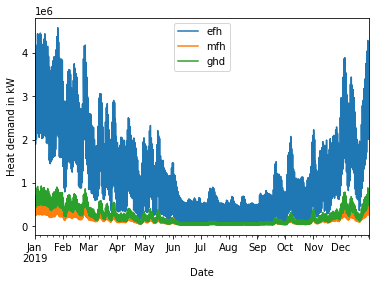

Annual consumption: 
efh    1.053928e+10
mfh    1.559710e+09
ghd    1.917517e+09
dtype: float64
                              efh            mfh            ghd
2019-01-01 00:00:00  1.923619e+06  248851.214259  474416.016555
2019-01-01 01:00:00  1.937609e+06  256597.555559  473052.752140
2019-01-01 02:00:00  1.958594e+06  261439.018871  513950.684602
2019-01-01 03:00:00  2.056523e+06  280804.872121  560301.674725
2019-01-01 04:00:00  2.238393e+06  335029.261220  711624.024833
...                           ...            ...            ...
2019-12-31 19:00:00  3.543777e+06  475902.570976  614064.591125
2019-12-31 20:00:00  3.456277e+06  460905.641219  568751.936818
2019-12-31 21:00:00  3.106274e+06  422913.419166  515626.755906
2019-12-31 22:00:00  2.486478e+06  373923.448624  478126.628204
2019-12-31 23:00:00  2.136475e+06  275943.507541  475001.617562

[8760 rows x 3 columns]


In [87]:
demand_2019=function_demand_lib(r'FILES\HEAT\averaget_by_hour_2019.csv',holidays_2019,pd.date_range(
            datetime.datetime(2019, 1, 1, 0), periods=8760, freq="H"),hours=8760)

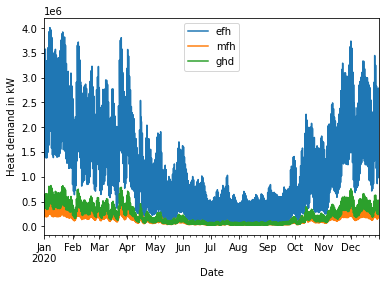

Annual consumption: 
efh    1.053931e+10
mfh    1.559689e+09
ghd    1.917538e+09
dtype: float64
                              efh            mfh            ghd
2020-01-01 00:00:00  1.400055e+06  192193.933137  377294.176312
2020-01-01 01:00:00  1.452557e+06  205448.687146  371745.732543
2020-01-01 02:00:00  1.464224e+06  209590.797774  422791.415221
2020-01-01 03:00:00  1.569228e+06  227816.084537  512676.204283
2020-01-01 04:00:00  1.750069e+06  279178.256323  609219.125869
...                           ...            ...            ...
2020-12-31 19:00:00  2.423524e+06  345546.737276  380239.764245
2020-12-31 20:00:00  2.370630e+06  337805.364343  355462.235748
2020-12-31 21:00:00  2.135009e+06  309654.917315  311625.069945
2020-12-31 22:00:00  1.591640e+06  265317.963245  283988.595852
2020-12-31 23:00:00  1.264656e+06  194238.084497  285894.559583

[8784 rows x 3 columns]


In [88]:
demand_2020=function_demand_lib(r'FILES\HEAT\averaget_by_hour_2020.csv',holidays_2020,pd.date_range(
            datetime.datetime(2020, 1, 1, 0), periods=8784, freq="H"),hours=8784)

Ukupni profil:

In [89]:
demand_2019["total_space"]=demand_2019[['efh', 'mfh',"ghd"]].sum(axis=1)
demand_2020["total_space"]=demand_2020[['efh', 'mfh',"ghd"]].sum(axis=1)

In [90]:
print("Toplotne potrebe za grijanje prostora, 2019.",demand_2019["total_space"].sum(axis=0)/1000000000,"TWh/god")
print("Toplotne potrebe za grijanje prostora, 2020.",demand_2020["total_space"].sum(axis=0)/1000000000,"TWh/god")

Toplotne potrebe za grijanje prostora, 2019. 14.016506479277604 TWh/god
Toplotne potrebe za grijanje prostora, 2020. 14.016534392276439 TWh/god


Anketa o potrošnji energije u domaćinstvima govori da 73% uzorkovanih domaćinstava koristi sobno grijanje, 19% vlastito grijanje a 8% grijanje iz toplana. Procijenjeni broj domaćinstava je: 1 033 452. Prema energetskom bilansu za 2020. domaćinstva troše 4107 TJ (1.14 TWh/god) toplote iz sistema DH, te se to poklapa sa procentom od oko 8% 

In [91]:
#Potrošnja po domaćinstvu:
per_household=((12099488+1917466.4)/1033452)

In [92]:
room=per_household*(0.73*1033452/1000000)
print("Sobno",room,"TWh/god")
own=per_household*(0.19*1033452/1000000)
print("Vlastito centralno",own,"TWh/god")

dh=per_household*((0.08*1033452)/1000000)
print("Toplane",dh,"TWh/god")


Sobno 10.232376712 TWh/god
Vlastito centralno 2.6632213360000003 TWh/god
Toplane 1.121356352 TWh/god


In [93]:
# Proizvedena toplota u toplanama
produced_plants=1.0786
produced_chp=0.4689
needs=1.1213
eta=needs/(produced_plants+produced_chp)
print(eta)
print("gubici",1-0.724)

0.7245880452342488
gubici 0.276


5% kod sobnog čini grijanje na struju, a 3% kod vlastitog centralnog. Sobno grijanje će se iskoristiti za sekciju "Electrical heating", a 3% od vlastitog centralnog će se iskoristiti u rubrici grijanja putem toplotnih pumpi. Prosječni COP toplotnih pumpi će se uzeti za neko od varijanti iz .ipynb fajla koji se odnosi na toplotne pumpe. Na grijanje na struju će se kasnije još dodati i energija za grijanje PTV.

In [94]:
elec_h=room*0.05
hp=own*0.03
print("Electrical heating - space only", elec_h,"TWh/god")
print("Heat pumps",hp,"TWh/god")

Electrical heating - space only 0.5116188356000001 TWh/god
Heat pumps 0.07989664008000001 TWh/god


## Metod stepen - dan (za distribuciju potreba za grijanjem i potreba za hlađenjem)

Metod stepen dan (HDD ili CDD) se može koristiti umjesto biblioteke demand_lib za toplotno opterećenje usljed grijanja (HDD), ali se isto tako može koristiti za distribuciju toplotnog opterećenja usljed hlađenja (CDD). U slučaju grijanja kao osnovna temperatura je odabrana temperatura od 20.5 °C. Kada temperatura u prostoriji opadne ispod osnovne, sistem grijanja se pali. Osnovna temperatura od 20.5°C je odabrana jer se time dobija približan broj stepen-dana koji izvještavaju Toplane Sarajevo za 2019. i 2020. godinu (3034 za 2019. i 3084. za 2020. godinu). Provjera je urađena sa temperaturom u Sarajevu za 2018. jer su to vrijednosti koje je dostavio FHMZ, dok NASA-ini podaci imaju nešto manju vjerodostojnost, te u tom slučaju HDD iznosi 3565. FHMZ nije dostavio podatke za 2020., dok je za 2019. dostaviov temperaturu za tek nekoliko mjeseci.
<br> Dalje će se distribucija modifikovati na način da se označe sezone grijanja koje su dostavile Toplane Sarajevo kao jedini takav podatak. To znači da se potrebe za grijanjem mogu označiti kao nulte u periodu 17.05 - 05.10. za 2019. i 11.05 -09.10. za 2020. godinu. Za 2021. će se iskoristiti podatak od 2019. jer je 2020. prestupna godina. 


In [95]:
#naći index datuma grijne sezone:

temp_cities[(temp_cities["YEAR"]==2019)&(temp_cities["MO"]==5)&(temp_cities["DY"]==18)&(temp_cities["HR"]==0)]

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
3288,2019,5,18,0,6.32,6.96,6.68,6.76,7.73,8.32,8.73,15.93


In [96]:
temp_cities[(temp_cities["YEAR"]==2019)&(temp_cities["MO"]==10)&(temp_cities["DY"]==6)&(temp_cities["HR"]==0)]

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
6672,2019,10,6,0,7.25,10.54,10.13,4.8,8.52,6.19,11.57,17.38


In [97]:
#naći index datuma:

temp_cities[(temp_cities["YEAR"]==2020)&(temp_cities["MO"]==5)&(temp_cities["DY"]==12)&(temp_cities["HR"]==0)]

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
11928,2020,5,12,0,9.68,13.44,13.19,7.46,12.94,9.49,14.76,16.49


In [98]:
#naći index datuma:

temp_cities[(temp_cities["YEAR"]==2020)&(temp_cities["MO"]==10)&(temp_cities["DY"]==18)&(temp_cities["HR"]==0)]

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
15744,2020,10,18,0,1.69,3.69,3.15,1.29,4.24,3.12,5.21,15.26


In [99]:
#naći index datuma:

temp_cities[(temp_cities["YEAR"]==2021)&(temp_cities["MO"]==5)&(temp_cities["DY"]==18)&(temp_cities["HR"]==0)]

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
20832,2021,5,18,0,6.38,7.98,7.59,4.8,7.67,6.12,9.28,16.9


In [100]:
temp_cities[(temp_cities["YEAR"]==2021)&(temp_cities["MO"]==10)&(temp_cities["DY"]==6)&(temp_cities["HR"]==0)]

,YEAR,MO,DY,HR,Sarajevo,Tuzla,Tesanj,Livno,Banjaluka,Mostar,Bijeljina,Trebinje
24216,2021,10,6,0,12.01,15.94,14.9,13.48,16.05,14.2,15.13,21.12


In [101]:
#FHMZ
HDD_2018=output1
difference_2018=(20.5-output1["temperature"].values )/24
HDD_2018=HDD_2018.assign(HDD=difference_2018)
HDD_2018.loc[3288:6672,"HDD"]=0
HDD_2018.loc[HDD_2018["HDD"]<=0,"HDD"]=0

In [102]:
HDD_2018["HDD"].sum()

3007.2937500000003

In [103]:
#NASA-ini podaci
HDD_NASA=output1
difference_NASA=(20.5-temp_cities[temp_cities["YEAR"]==2019]["Sarajevo"].values )/24
HDD_NASA=HDD_NASA.assign(HDD=difference_NASA)
HDD_NASA.loc[3288:6672,"HDD"]=0
HDD_NASA.loc[HDD_NASA["HDD"]<=0,"HDD"]=0
HDD_NASA["HDD"].sum()

3565.4020833333334

Za HDD distribuciju na nivou BiH će se iskoristiti izračunati prosjek temperatura po satima za nekoliko geografskih regija iz prethodnih koraka za 2019., 2020. i 2021. godinu. 

In [104]:

HDD_2019=averaget_by_hour_2019
difference_2019=(20.5-HDD_2019["temperature"].values )/24

HDD_2019=HDD_2019.assign(HDD=difference_2019)
HDD_2019.loc[3288:6672,"HDD"]=0
HDD_2019.loc[HDD_2019["HDD"]<=0,"HDD"]=0

HDD_2020=averaget_by_hour_2020
difference_2020=(20.5-HDD_2020["temperature"].values )/24

HDD_2020=HDD_2020.assign(HDD=difference_2020)
HDD_2020.loc[11928:15744,"HDD"]=0
HDD_2020.loc[HDD_2020["HDD"]<=0,"HDD"]=0

HDD_2021=averaget_by_hour_2021
difference_2021=(20.5-HDD_2021["temperature"].values )/24
HDD_2021=HDD_2021.assign(HDD=difference_2021)
HDD_2021.loc[20832:24216,"HDD"]=0
HDD_2021.loc[HDD_2021["HDD"]<=0,"HDD"]=0

In [105]:
print("HDD - 2019.",HDD_2019["HDD"].sum())
print("HDD - 2020.",HDD_2020["HDD"].sum())
print("HDD - 2021.",HDD_2021["HDD"].sum())

HDD - 2019. 3018.424375
HDD - 2020. 2919.4433854166664
HDD - 2021. 3354.6008854166666


<AxesSubplot:>

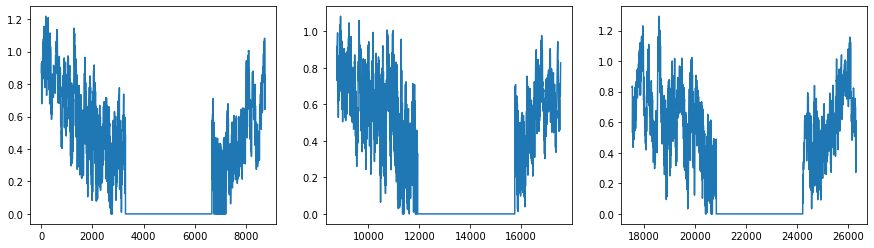

In [106]:
fig,ax=plt.subplots(ncols=3, figsize=(15,4))

HDD_2019["HDD"].plot(ax=ax[0])
HDD_2020["HDD"].plot(ax=ax[1])
HDD_2021["HDD"].plot(ax=ax[2])

Sada će se svaka vrijednost skalirati kao procenat od sume: 

In [107]:
HDD_2019["Ratio"]=HDD_2019["HDD"]/HDD_2019["HDD"].sum(axis=0)
HDD_2020["Ratio"]=HDD_2020["HDD"]/HDD_2020["HDD"].sum(axis=0)
HDD_2021["Ratio"]=HDD_2021["HDD"]/HDD_2021["HDD"].sum(axis=0)

In [108]:
HDD_2019["total_space"]=HDD_2019["Ratio"]*demand_2019["total_space"].sum(axis=0)
HDD_2020["total_space"]=HDD_2020["Ratio"]*demand_2020["total_space"].sum(axis=0)
#HDD_2021["Demand"]=HDD_2021["Ratio"]*demand_2021["total_space"].sum(axis=0)

CDD distribucija će se računati za temperaturu u prostoru od 26°C. Ovaj dio je potreban za sekciju "Individual Cooling - airconditioning" jer se ostatak odnosi na apsorpciono hlađenje (dio pod District cooling)

In [109]:

CDD_2019=averaget_by_hour_2019
difference_2019=(CDD_2019["temperature"].values-26)/24
CDD_2019=CDD_2019.assign(CDD=difference_2019)
CDD_2019.loc[CDD_2019["CDD"]<=0,"CDD"]=0

CDD_2020=averaget_by_hour_2020
difference_2020=(CDD_2020["temperature"].values-26 )/24
CDD_2020=CDD_2020.assign(CDD=difference_2020)
CDD_2020.loc[CDD_2020["CDD"]<=0,"CDD"]=0


CDD_2021=averaget_by_hour_2021
difference_2021=(CDD_2021["temperature"].values-26)/24
CDD_2021=CDD_2021.assign(CDD=difference_2021)
CDD_2021.loc[CDD_2021["CDD"]<=0,"CDD"]=0


<AxesSubplot:>

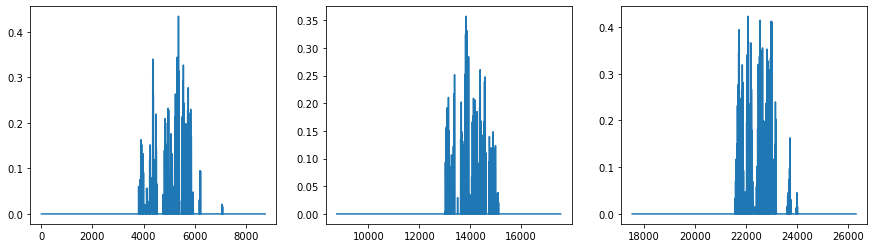

In [110]:
fig,ax=plt.subplots(ncols=3, figsize=(15,4))

CDD_2019["CDD"].plot(ax=ax[0])
CDD_2020["CDD"].plot(ax=ax[1])
CDD_2021["CDD"].plot(ax=ax[2])

## Potrošnja PTV

Prema FIDE vodiču https://energyplan.eu/wp-content/uploads/2013/06/Finding-and-Inputting-Data-into-the-EnergyPLAN-Tool-v5.pdf 
profil toplotnih potreba treba da obuhvati i pripremu PTV. U ljetnim mjesecima grijanje, dok se potrošnja vode obično smatra manje podložnom sezonskim promjenama jer ljudi koriste uglavnom istu količinu vode neovisno od temperature tokom godine. U vodiču je nađen podatak da je odnos potrošnje energije za grijanje i PTV 7:3. Prema tome, ako su ukupne potrebe 14 016 954 MWh/god (stambene + javne zgrade), potrošnja energije za PTV je 6007266.17 MWh/god. Za profil potrošnje PTV će se iskoristiti srednji profil iz Hrvatske za različite vrste objekata (SFH,MFH i COM). 
<br>**Iterativnim postupkom je utvrđeno da se iznos od 6007266.17 MWh/god mora umanjiti da bi se od ukupnih potreba za električnom energijom u satnoj distribuciji mogao oduzeti dio koji se odnosi na električnu energiju za grijanje i hlađenje, te se ovaj dio smanjio na 40% od dijela dobivenog omjerom 7:3.

In [111]:
print(((12099488+1917466.4)*3/7)/1000000,"TWh/god")

6.007266171428571 TWh/god


Ukupna potrošnja toplote toplotne energije će biti:

In [112]:
print(14016954+6007266.171428571,"MWh/god")
print((14016954+6007266.171428571)/1000000,"TWh/god")

20024220.171428572 MWh/god
20.024220171428574 TWh/god


In [113]:
print("Potrošnja energije za PTV:",(6007266.171428571/1000000)*0.4,"TWh/god")#iteracije

Potrošnja energije za PTV: 2.4029064685714285 TWh/god


In [114]:
print("Ukupna potrošnja, grijanje na struju - PTV i prostor",0.5116188356 +2.4029064685714285,"TWh/god")

Ukupna potrošnja, grijanje na struju - PTV i prostor 2.9145253041714287 TWh/god


Profil potrošnje energije za PTV će se napraviti tako što će se hrvatski profili za svaku dostupnu godinu skalirati u odnosu na godišnju potrošnju (varijabla years1). Ti skalirni koeficijenti će se usrednjiti te se onda pomonžiti sa procijenjenom potrošnjom energije za PTV u BiH od 2.40 TWh/god. Ukupne toplotne potrebe su dalje zbir toplotnih potreba za grijanje prostora i toplotnih potreba za PTV, te se one spašavaju u fajl oblika demand_xxxx.txt.

In [115]:
BH_demand_water=pd.DataFrame(years1.groupby("Hourofyear")['water_heat_demand_MW/TWh'].mean())

In [116]:
BH_demand_water['water_heat_demand_MW']=BH_demand_water['water_heat_demand_MW/TWh']*2.4029

In [117]:
len(BH_demand_water)

8784

In [118]:
demand_2019["total"]=demand_2019["total_space"].values+BH_demand_water['water_heat_demand_MW'].values[:8760]
demand_2020["total"]=demand_2020["total_space"].values+BH_demand_water['water_heat_demand_MW'].values

In [119]:
zeros = pd.DataFrame(0, index=np.arange(24),columns=demand_2019.columns)
demand_2019= pd.concat([demand_2019, zeros])
print("8784 vrijednosti, zadnjih 24 su nule")

8784 vrijednosti, zadnjih 24 su nule


In [120]:
demand_2019["total"].to_csv(r'EnergyPLAN files\Heat\Hourly\demand_2019.txt', index=False,header=0,decimal=",",sep=" ")
demand_2020["total"].to_csv(r'EnergyPLAN files\Heat\Hourly\demand_2020.txt', index=False,header=0,decimal=",",sep=" ")

Za HDD metod:

In [121]:
HDD_2019["total"]=HDD_2019["total_space"].values+BH_demand_water['water_heat_demand_MW'].values[:8760]
HDD_2020["total"]=HDD_2020["total_space"].values+BH_demand_water['water_heat_demand_MW'].values

In [122]:
zeros = pd.DataFrame(0, index=np.arange(24),columns=HDD_2019.columns)
HDD_2019= pd.concat([HDD_2019, zeros])
HDD_2021= pd.concat([HDD_2021, zeros])
print("8784 vrijednosti, zadnjih 24 su nule")

8784 vrijednosti, zadnjih 24 su nule


In [123]:
HDD_2019["total"].to_csv(r'EnergyPLAN files\Heat\Hourly\HDD_BH_2019.txt', index=False,header=0,decimal=",",sep=" ")
HDD_2020["total"].to_csv(r'EnergyPLAN files\Heat\Hourly\HDD_BH_2020.txt', index=False,header=0,decimal=",",sep=" ")

In [124]:
HDD_2019["total"].shape

(8784,)

## CDD distribucija:

In [125]:
CDD_2019[["YEAR","MO","DY","HR"]]=temp_cities[temp_cities["YEAR"]==2019][["YEAR","MO","DY","HR"]]
CDD_2020[["YEAR","MO","DY","HR"]]=temp_cities[temp_cities["YEAR"]==2020][["YEAR","MO","DY","HR"]]
CDD_2021[["YEAR","MO","DY","HR"]]=temp_cities[temp_cities["YEAR"]==2021][["YEAR","MO","DY","HR"]]

Broj dana u godini kada je CDD>0 (postoji potreba za hlađenjem):

In [126]:

cooling_days_2019=[len(i) for i in (CDD_2019[CDD_2019["CDD"]>0].groupby(["MO"])["DY"].unique()).values]
print("2019", sum(cooling_days_2019))

cooling_days_2020=[len(i) for i in (CDD_2020[CDD_2020["CDD"]>0].groupby(["MO"])["DY"].unique()).values]
print("2020", sum(cooling_days_2020))

cooling_days_2021=[len(i) for i in (CDD_2021[CDD_2021["CDD"]>0].groupby(["MO"])["DY"].unique()).values]
print("2021", sum(cooling_days_2021))

2019 72
2020 65
2021 72


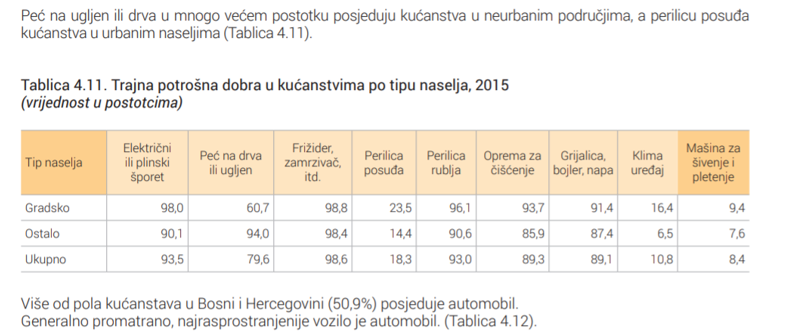

Prema Anketi o potrošnju u domaćinstvima, 10.8% uzorka posjeduje klima uređaj, te će se ovaj podatak iskoristiti za procjenu energije za hlađenje prostora (uzimajući u obzir snagu klima uređaja od 3.5 kW - podatak pronađen na internetu je u rasponu (3 - 3.5) kW https://americanhomewater.com/how-much-power-does-an-air-conditioner-use/#:~:text=Generally%20speaking%2C%20however%2C%20you%20can,range%20between%20900%20and%201440.). Za procjenu će se uzeti da klima uređaj radi četiri sata dnevno u domaćinstvima. Procijenjeni broj domaćinstava je: 1 033 452.


In [127]:
#potrošnja će se procijeniti....

household_cooling_2019=(3.5*4*0.1*1033452*72)/1000000000
household_cooling_2020=(3.5*4*0.1*1033452*65)/1000000000
household_cooling_2021=(3.5*4*0.1*1033452*72)/1000000000
print("Potrebe za hlađenjem domaćinstava 2019",household_cooling_2019,"TWh/god")
print("Potrebe za hlađenjem domaćinstava 2020",household_cooling_2020,"TWh/god")
print("Potrebe za hlađenjem domaćinstava 2021",household_cooling_2021,"TWh/god")

Potrebe za hlađenjem domaćinstava 2019 0.10417196160000002 TWh/god
Potrebe za hlađenjem domaćinstava 2020 0.094044132 TWh/god
Potrebe za hlađenjem domaćinstava 2021 0.10417196160000002 TWh/god


Procijenjeni broj javnih zgrada u BiH prema Tiplogiji javnih zgrada iznosi 7600. Na internetu je pronađen podatak za vršno opterećenje hlađenja za nove objekte u opsegu od (100-180) W/m^2 za kancelarijske objekte, (120 - 260)W/m^2 za hotele i (250 - 350) W/m^2  za maloprodajne objekte. Stvarno opterećenje je manje. Kao pretpostavka za različite tipove objekata u nastavku uzet će se da je opterećenje hlađenja 200 W/m^2. 

Ukupna korisna površina grijanog dijela i zapremina grijanog dijela svih javnih zgrada u BiH
    
|          |obdaništa|obrazovanje|zdravstvo|sport|kultura|kancelarijske zgrade|cjelodnevni boravak|
| --- | --- | --- | --- | --- | --- | --- | --- |
|<b>Površina grijanog dijela, $m^2$<b>	|2 868 181	|939 842|505 714	|686 371|2 495 033|1 457 588|9 075 438|
|<b>Zapremina grijanog zraka, $m^3$<b>	|9 555 436|2 957 759|3 531 641|2 511 397|7 767 041|4782410|31 498 733|
|<b>Prosječan broj dnevnih radnih sati<b>|9,7|9,5|13,4|10,6|10,4|11,3|20|
    
<b>Osim javnih zgrada, hlađenje se vrši i u drugim objektima koji nisu javne zgrade, te će se vrijednost površine povećati za 20%, s tim da za ovaj procenat nema uporišta, već je eksperimentalno zadat.<b> Također, nemaju svi objekti uređaje za hlađenje, te će se pretpostaviti da je u pitanju nekih 50% objekata. Uzet će se da se hlađenje vrši pola radnog vremena

Procijenjeni broj javnih zgrada u BiH je 7600
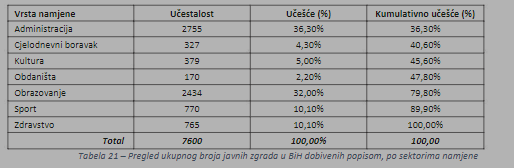

In [128]:
per_building=200 #W/m2
area=(2868181+939842+505714+686371+2495033+1457588+9075438)#m2
area_with_other_buildings=1.2*area #m2
partial_area=area_with_other_buildings*0.5
average_hour=((9.7+9.5+13.4+10.6+10.4+11.3+20)/7)*0.5
cooling_load_2019=(partial_area*per_building*average_hour*72)/1000000000000
cooling_load_2020=(partial_area*per_building*average_hour*65)/1000000000000
cooling_load_2021=(partial_area*per_building*average_hour*72)/1000000000000
print("Potrebe za hlađenjem javni i drugi objekti 2019",cooling_load_2019,"TWh/god")
print("Potrebe za hlađenjem javni i drugi objekti 2020",cooling_load_2020,"TWh/god")
print("Potrebe za hlađenjem javni i drugi objekti 2021",cooling_load_2021,"TWh/god")

Potrebe za hlađenjem javni i drugi objekti 2019 0.9445935363222858 TWh/god
Potrebe za hlađenjem javni i drugi objekti 2020 0.8527580536242858 TWh/god
Potrebe za hlađenjem javni i drugi objekti 2021 0.9445935363222858 TWh/god


In [129]:
print("Ukupne potrebe za hlađenjem 2019.",household_cooling_2019+cooling_load_2019,"TWh/god")
print("Ukupne potrebe za hlađenjem 2020.",household_cooling_2020+cooling_load_2020,"TWh/god")
print("Ukupne potrebe za hlađenjem 2021.",household_cooling_2021+cooling_load_2021,"TWh/god")

Ukupne potrebe za hlađenjem 2019. 1.0487654979222858 TWh/god
Ukupne potrebe za hlađenjem 2020. 0.9468021856242859 TWh/god
Ukupne potrebe za hlađenjem 2021. 1.0487654979222858 TWh/god


Potrošnja električne energije će se uzeti za COP =4.3, što je praćeno na osnovu vrijednosti COP za uređaje snage <4 kW u Boilers_Heat_pumps.ipynb

In [130]:
print("Ukupne potrebe za hlađenjem 2019.",(household_cooling_2019+cooling_load_2019)/4.3,"TWh/god")
print("Ukupne potrebe za hlađenjem 2020.",(household_cooling_2020+cooling_load_2020)/4.3,"TWh/god")
print("Ukupne potrebe za hlađenjem 2021.",(household_cooling_2021+cooling_load_2021)/4.3,"TWh/god")

Ukupne potrebe za hlađenjem 2019. 0.24389895300518274 TWh/god
Ukupne potrebe za hlađenjem 2020. 0.22018655479634555 TWh/god
Ukupne potrebe za hlađenjem 2021. 0.24389895300518274 TWh/god


In [131]:
zeros = pd.DataFrame(0, index=np.arange(24),columns=CDD_2019.columns)
CDD_2019= pd.concat([CDD_2019, zeros])
print("8784 vrijednosti, zadnjih 24 su nule")

8784 vrijednosti, zadnjih 24 su nule


In [132]:
CDD_2019["CDD"].to_csv(r'EnergyPLAN files\Heat\Hourly\CDD_BH_2019.txt', index=False,header=0,decimal=",",sep=" ")
CDD_2020["CDD"].to_csv(r'EnergyPLAN files\Heat\Hourly\CDD_BH_2020.txt', index=False,header=0,decimal=",",sep=" ")

<AxesSubplot:>

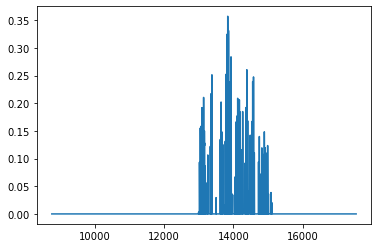

In [133]:
CDD_2020["CDD"].plot()

In [134]:
CDD_2019["scaled"]=CDD_2019["CDD"].values/CDD_2019["CDD"].max(axis=0)
CDD_2020["scaled"]=CDD_2020["CDD"].values/CDD_2020["CDD"].max(axis=0)

CDD_2019["scaled"].to_csv(r'EnergyPLAN files\Heat\Hourly\CDD_BH_2019.txt', index=False,header=0,decimal=",",sep=" ")
CDD_2020["scaled"].to_csv(r'EnergyPLAN files\Heat\Hourly\CDD_BH_2020.txt', index=False,header=0,decimal=",",sep=" ")

<AxesSubplot:>

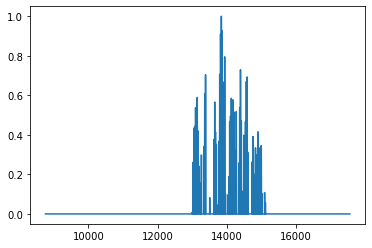

In [135]:
CDD_2020["scaled"].plot()

U FIDE vodiču je na osnovu izvještaja SEAI konstatovano da 14% potrošnje energije u domaćinstvu se koristi za grijanje prostora a 23% za grijanje PTV.
U drugom izvještaju iste organizacije je konstatovano da 12% električne energije u komercijalnim objektima se troši na grijanje. Prema tome, indikator potrošnje električne energije za grijanje je 37% potrošnje u domaćinstvima i 12% kod drugih kupaca električne energije
